In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Metrics

In [39]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    eq_sf = np.array([np.where(time > t, 1, 0)
                      for i, t in enumerate(bins)]).T
    
    kl_v = np.sum(sf * np.log((sf + 1e-10)/(eq_sf + 1e-10)) + np.abs(sf - eq_sf), axis=0)
    return np.trapz(kl_v, bins, axis=0) / (bins[-1] - bins[0])

In [541]:
def ibs(*args, **kwargs):
    return metr.ibs(*args, **kwargs)

def bal_ibs(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

def bal_ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_WW(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_WW(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2


def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    
    ind = np.digitize(test_time, times) - 1
    n_cens = np.bincount(ind[~test_event], minlength=times.shape[0])
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                        for i, t in enumerate(times)]), axis=1)

    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)        
        return brier_scores
    return None

def bal_ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_remain(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_remain(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

ibs_list = [ibs, bal_ibs, 
            ibs_WW, bal_ibs_WW,
            ibs_remain, bal_ibs_remain]

In [505]:
import sksurv.metrics
import numpy as np
from numba import njit, jit
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

def iauc(survival_train, survival_test, estimate, times, tied_tol=1e-8, axis=-1):
    if survival_train["cens"].sum() == 0:
        survival_train["cens"] = 1
        survival_test["cens"] = 1 - survival_test["cens"]
    if survival_test["cens"].sum() == 0:
        survival_test["cens"] = 1
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate = np.array(estimate)
    n_samples = estimate.shape[0]
    n_times = times.shape[0]
    if estimate.ndim == 1:
        estimate = np.broadcast_to(estimate[:, np.newaxis], (n_samples, n_times))

    # fit and transform IPCW
    cens = sksurv.metrics.CensoringDistributionEstimator()
    cens.fit(survival_train)
    Ghat = cens.predict_proba(test_time[test_event])
    ipcw = np.zeros(test_time.shape[0])
    Ghat[Ghat == 0] = np.inf
    if not((Ghat == 0.0).any()):
        ipcw[test_event] = 1.0 / Ghat
    else:
        ipcw = np.ones(test_time.shape[0])

    # expand arrays to (n_samples, n_times) shape
    test_time = np.broadcast_to(test_time[:, np.newaxis], (n_samples, n_times))
    test_event = np.broadcast_to(test_event[:, np.newaxis], (n_samples, n_times))
    times_2d = np.broadcast_to(times, (n_samples, n_times))
    ipcw = np.broadcast_to(ipcw[:, np.newaxis], (n_samples, n_times))

    # sort each time point (columns) by risk score (descending)
    o = np.argsort(-estimate, axis=0)
    test_time = np.take_along_axis(test_time, o, axis=0)
    test_event = np.take_along_axis(test_event, o, axis=0)
    estimate = np.take_along_axis(estimate, o, axis=0)
    ipcw = np.take_along_axis(ipcw, o, axis=0)

    is_case = (test_time <= times_2d) & test_event
    is_control = test_time > times_2d
    n_controls = is_control.sum(axis=0)

    # prepend row of infinity values
    estimate_diff = np.concatenate((np.broadcast_to(np.infty, (1, n_times)), estimate))
    is_tied = np.absolute(np.diff(estimate_diff, axis=0)) <= tied_tol

    cumsum_tp = np.cumsum(is_case * ipcw, axis=0)
    cumsum_fp = np.cumsum(is_control, axis=0)
    true_pos = cumsum_tp / cumsum_tp[-1]
    false_pos = cumsum_fp / n_controls

    scores = np.empty(n_times, dtype=float)
    it = np.nditer((true_pos, false_pos, is_tied), order="F", flags=["external_loop"])
    with it:
        for i, (tp, fp, mask) in enumerate(it):
            idx = np.flatnonzero(mask) - 1
            # only keep the last estimate for tied risk scores
            tp_no_ties = np.delete(tp, idx)
            fp_no_ties = np.delete(fp, idx)
            # Add an extra threshold position
            # to make sure that the curve starts at (0, 0)
            tp_no_ties = np.r_[0, tp_no_ties]
            fp_no_ties = np.r_[0, fp_no_ties]
            scores[i] = np.trapz(tp_no_ties, fp_no_ties)

    scores[np.isnan(scores)] = 0
    if n_times == 1:
        return scores[0]
    
    if axis == -1:  # mean iauc for each time and observation
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        # compute integral of AUC over survival function
        d = -np.diff(np.r_[1.0, s_times])
        integral = (scores * d).sum()
        return integral / (1.0 - s_times[-1])
    elif axis == -2:
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        return np.trapz(scores, -s_times) / (s_times[0] - s_times[-1])
    elif axis == 0:  # ibs for each observation
        return None
    elif axis == 1:  # bs in time (for graphics)
        return scores
    return mean_auc

### Datasets loading

In [559]:
import survivors.datasets as ds
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_smarto_dataset()

### Bins schemes

In [560]:
def bins_scheme(val, scheme=""):
    if scheme == "rank":
        u = np.unique(val)
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")
    if scheme == "quantile":
        u = np.unique(np.quantile(val, np.linspace(0, 1, 100)))
        # u = np.hstack([0.0, np.quantile(val, np.linspace(0, 1, 100)), val.max()])
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")  # u[ind].astype("int")
    if scheme == "log+scale":
        a = np.log(val+1)
        v = (val.max() - val.min())*(a - a.min())/(a.max() - a.min()) + val.min()
        return v.astype("int")
    return val

(-128.75, 2791.75)

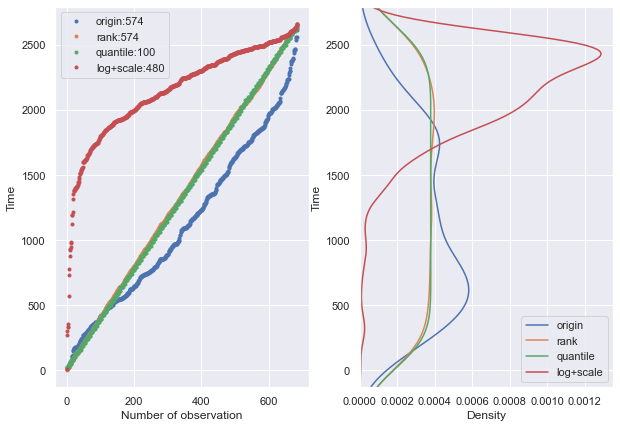

In [561]:
fig, axes = plt.subplots(figsize=(10, 7), ncols=2)
for scheme in ["origin", "rank", "quantile", "log+scale"]:
    y_new = y.copy()
    #y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
    y_ = np.sort(bins_scheme(y_new["time"], scheme=scheme))
    axes[0].plot(y_, label=f"{scheme}:{np.unique(y_).shape[0]}", marker='o', markersize=3, linestyle="")
    
    sns.kdeplot(y=bins_scheme(y_new["time"], scheme=scheme), label=f"{scheme}", ax=axes[1])
axes[0].legend()
axes[0].set_xlabel("Number of observation")
axes[0].set_ylabel("Time")

axes[1].legend()
axes[1].set_ylabel("Time")


ymin, ymax = axes[0].get_ylim()
axes[1].set_ylim(ymin, ymax)

### Dependence IBS on true event time

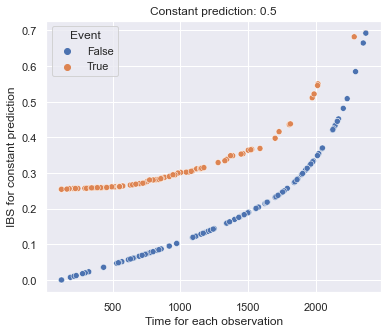

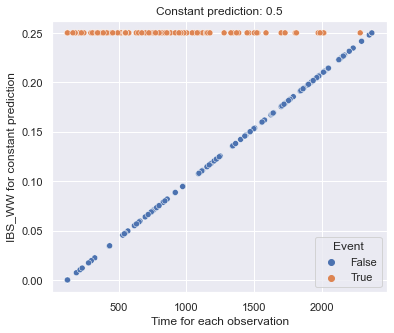

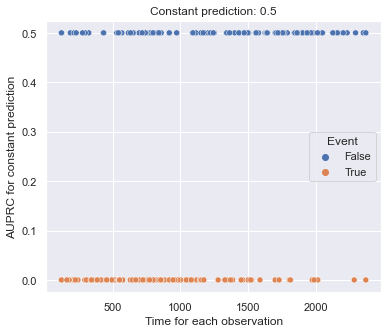

In [562]:
from survivors.experiments.grid import generate_sample

def plot_dependence_of_obs(X, y, metric, cnt_p=0.5): # [0.0, 0.5, 1.0]
    plt.figure(figsize=(6, 5))
    for scheme in ["origin"]:
        y_new = y.copy()
        y_new["time"] = bins_scheme(y_new["time"], scheme=scheme)
        for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y_new, 5, "CV+HOLD-OUT"):
            pass
        ibs_all = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=-1)
        ibs_cnt_p = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=0)
        pd_data = pd.DataFrame(y_HO)
        pd_data["Event"] = pd_data["cens"]
        sns.scatterplot(data=pd_data, x="time", y=ibs_cnt_p, hue="Event", palette="deep")
    plt.title(f"Constant prediction: {cnt_p}")
    plt.xlabel("Time for each observation")
    plt.ylabel(f"{metric.__name__.upper()} for constant prediction")
    plt.show()

plot_dependence_of_obs(X, y, metr.ibs)
plot_dependence_of_obs(X, y, metr.ibs_WW)
plot_dependence_of_obs(X, y, metr.auprc)

### Dependence IBS and IAUC on bins

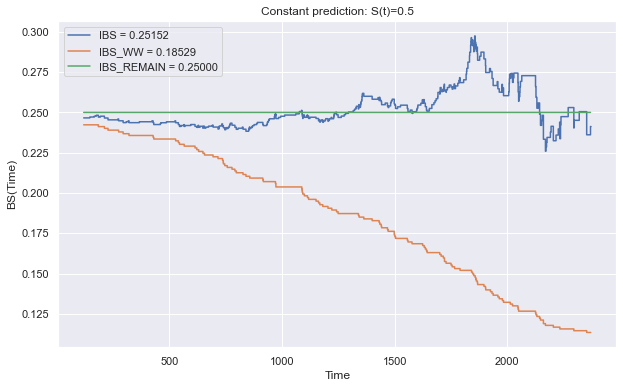

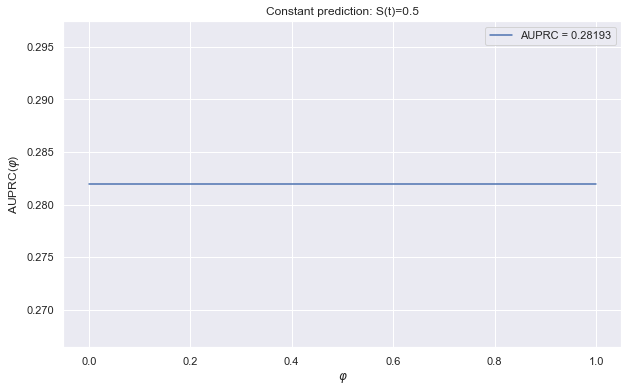

In [563]:
from survivors.experiments.grid import generate_sample

def plot_dependence_of_time(X, y, l_metrics):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass
    plt.figure(figsize=(10, 6))
    for m in l_metrics:
        bins = bins[:-1]
        base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5

        m_all = m(y_tr, y_HO, base_sf, bins, axis=1)
        m_mean = m(y_tr, y_HO, base_sf, bins, axis=-1)
        
        if m.__name__.find("auprc") != -1:
            bins = np.linspace(0, 1, 100)
        plt.step(bins, m_all,  label=f"{m.__name__.upper()} = {m_mean:.5f}")
    
    plt.legend()
    plt.title(f"Constant prediction: S(t)=0.5")
    plt.xlabel("Time")
    if m.__name__.find("auprc") != -1:
        plt.xlabel(r"$\varphi$")
        plt.ylabel(r"AUPRC($\varphi$)")
    else:
        plt.xlabel("Time")
        plt.ylabel("BS(Time)")

plot_dependence_of_time(X, y, [metr.ibs, metr.ibs_WW, metr.ibs_remain])
plot_dependence_of_time(X, y, [metr.auprc])

Text(0, 0.5, 'AUC(Time)')

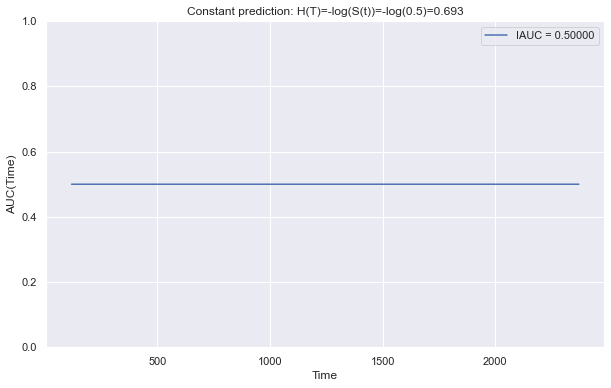

In [564]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(10, 6))
for m in [iauc]:
    bins = bins[:-1]
    base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    base_hf = -np.log(base_sf)
    kmf = KaplanMeierFitter()

    kmf.fit(y_HO["time"], y_HO["cens"])
    one_km_sf = kmf.survival_function_at_times(bins).to_numpy()
    km_sf = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
    base_hf = -np.log(km_sf)

    m_all = m(y_tr, y_HO, base_hf, bins, axis=1)
    m_mean = m(y_tr, y_HO, base_hf, bins, axis=-1)
    plt.step(bins, m_all,  label=f"{m.__name__.upper()} = {m_mean:.5f}") #label=f"max bins:{max_time}, ibs={ibs_mean:.5f}")

# plt.step(bins, km_sf[0])
plt.legend()
plt.ylim((0.0, 1.0))
plt.title(f"Constant prediction: H(T)=-log(S(t))=-log(0.5)=0.693")
plt.xlabel("Time")
plt.ylabel("AUC(Time)")

Text(0, 0.5, 'Impact')

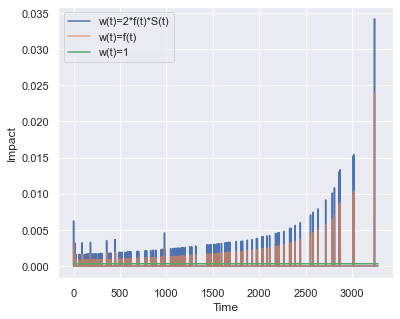

In [510]:
# h_est = np.hstack([0.0, -np.diff(np.log(one_km_sf))])
f_est = np.hstack([0.0, -np.diff(one_km_sf)])
plt.figure(figsize=(6, 5))
plt.step(bins, 2*one_km_sf*f_est,  label=f"w(t)=2*f(t)*S(t)", alpha=1)
plt.step(bins, f_est,  label=f"w(t)=f(t)", alpha=0.7)
plt.step(bins, np.ones_like(bins)/(bins[-1] - bins[0]), label=f"w(t)=1")
# plt.step(bins, km_sf[0])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

Text(0, 0.5, 'Impact')

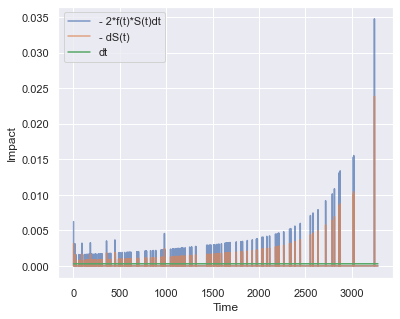

In [512]:
plt.figure(figsize=(6, 5))
plt.step(bins[1:], -1*np.diff(km_sf**2)[0],  label=f"- 2*f(t)*S(t)dt", alpha=0.7)
plt.step(bins[1:], -1*np.diff(km_sf)[0],  label=f"- dS(t)", alpha=0.7)
# plt.step(bins, km_sf[0])
plt.step(bins[1:], np.diff(bins)/(bins[-1] - bins[0]), label=f"dt")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

### Disbalance analysis

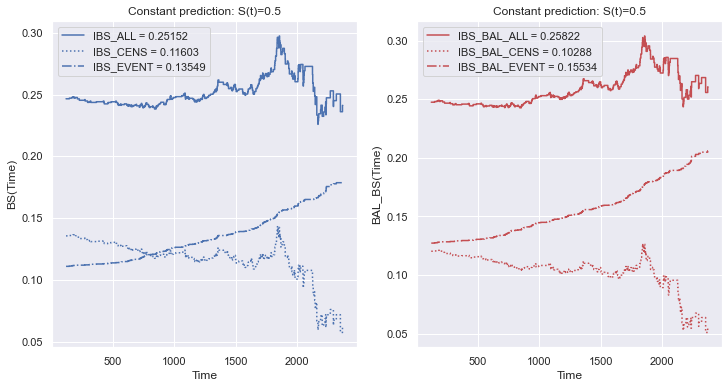

In [568]:
from survivors.experiments.grid import generate_sample

def plot_disbalance(X, y, m, m_bal):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass

    fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
    bins = bins[:-1]
    best_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    best_hf = -np.log(best_sf)

    N_event = np.sum(y_HO["cens"])
    N_cens = y_HO.shape[0] - N_event
    N = y_HO.shape[0]

    m_event = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=1)
    m_event_val = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=-1)

    m_cens = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=1)
    m_cens_val = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=-1)

    m_all = m(y_tr, y_HO, best_sf, bins, axis=1)
    m_all_val = m(y_tr, y_HO, best_sf, bins, axis=-1)

    m_bal_arr = m_bal(y_tr, y_HO, best_sf, bins, axis=1)
    m_bal_mean = m_bal(y_tr, y_HO, best_sf, bins, axis=-1)

    #plt.fill_between(bins_, ibs_all, step="pre", alpha=0.3)
    if m.__name__.find("auprc") != -1:
        bins = np.linspace(0, 1, 100)
        axes[0].step(bins, m_all,  label=f"AUPRC_ALL = {m_all_val:.5f}", color="b")
        axes[0].step(bins, m_cens,  label=f"AUPRC_CENS = {m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, m_event,  label=f"AUPRC_EVENT = {m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=f"AUPRC_BAL_ALL = {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens,  label=f"AUPRC_BAL_CENS = {m_cens_val:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event,  label=f"AUPRC_BAL_EVENT = {m_event_val:.5f}", ls='-.', color="r")
    else:
        axes[0].step(bins, m_all,  label=f"IBS_ALL = {m_all_val:.5f}", color="b")
        axes[0].step(bins, N_cens/N*m_cens,  label=f"IBS_CENS = {N_cens/N*m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, N_event/N*m_event,  label=f"IBS_EVENT = {N_event/N*m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=f"IBS_BAL_ALL = {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens/2,  label=f"IBS_BAL_CENS = {m_cens_val/2:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event/2,  label=f"IBS_BAL_EVENT = {m_event_val/2:.5f}", ls='-.', color="r")
    #     plt.step(bins, ibs_bal,  label=f"IBS_BAL = {ibs_bal_mean:.5f}", color="r")

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(f"Constant prediction: S(t)=0.5")
    axes[1].set_title(f"Constant prediction: S(t)=0.5")
    if m.__name__.find("auprc") != -1:
        axes[0].set_xlabel(r"$\varphi$")
        axes[1].set_xlabel(r"$\varphi$")
        axes[0].set_ylabel(r"AUPRC($\varphi$)")
        axes[1].set_ylabel(r"BAL_AUPRC($\varphi$)")
    else:
        axes[0].set_xlabel("Time")
        axes[1].set_xlabel("Time")
        axes[0].set_ylabel("BS(Time)")
        axes[1].set_ylabel("BAL_BS(Time)")

plot_disbalance(X, y, ibs, bal_ibs) # metr.auprc, metr.bal_auprc) # metr.ibs, metr.bal_ibs)

In [427]:
group = "bstr_full_WB" # "bstr_full_WB"  # "scsurv"

glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
glob_dir = os.path.join(glob_dir, group)

In [580]:
def to_str_from_dict_list(d, strat):
    if isinstance(strat, str):
        return str(d.get(strat, ""))
    elif isinstance(strat, list):
        return ";".join([str(d.get(e, "")) for e in strat])
    return None

def print_res_sample(datas: list):
    feats = ["CRIT", "CI_mean",
             "IAUC_mean", "IAUC_TI_mean",
             "AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"]
#     fig, axes = plt.subplots(figsize=(15, 6), ncols=3)
    lst_df = []
    for dat in datas:
        print("="*10, dat[-dat[::-1].find("\\"):], "="*10)
        res_table = pd.read_excel(os.path.join(glob_dir, dat))
        res_table["Stratify"] = res_table["PARAMS"].apply(lambda x: to_str_from_dict_list(eval(x), ["criterion", "ens_metric_name"]))
        res_table["Stratify"] = res_table["METHOD"] + "(" + res_table["Stratify"] + ")"
        res_table.set_index("Stratify")[feats].round(4).to_csv(dat[:-5]+"_res.csv", sep="&")
#         lst_df.append(res_table)
    
#     full_df = pd.concat(lst_df)
#     for i, m in enumerate(["CI", "AUPRC", "BAL_AUPRC"]):
#         full_df[m] = full_df[m].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
#         explode_res = full_df.loc[:, [m, "Stratify"]].set_index(['Stratify']).apply(lambda x: x.explode()).reset_index()
#         explode_res.boxplot(column=m, by="Stratify", rot=45, ax=axes[i])
#     plt.show()

ch_metrs = ["likelihood"]  # ["conc", "IBS", "IBS_WW", "IBS_REMAIN"]
for dataset in ["flchain"]: #["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg", "flchain"]:
    print("="*10, dataset, "="*10)
    datasets_sc = [f"{metr}_{group}_origin_{dataset}_CV+SAMPLE_best.xlsx" for metr in ch_metrs]
    print_res_sample(datasets_sc)

========== flchain ==========
========== ikelihood_bstr_full_WB_origin_flchain_CV+SAMPLE_best.xlsx ==========


========== GBSG ==========


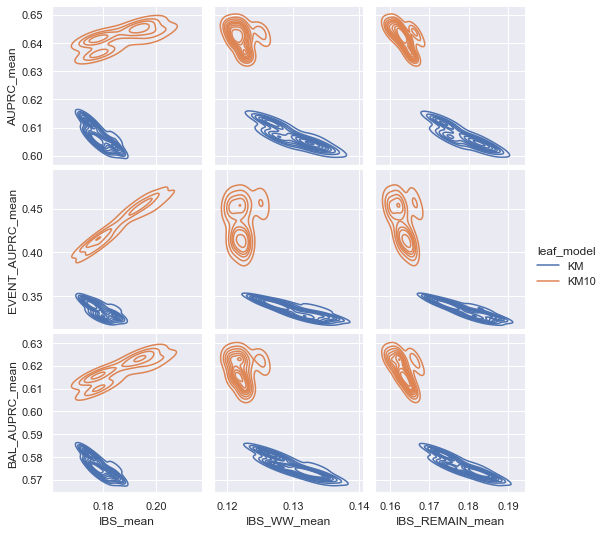

========== PBC ==========


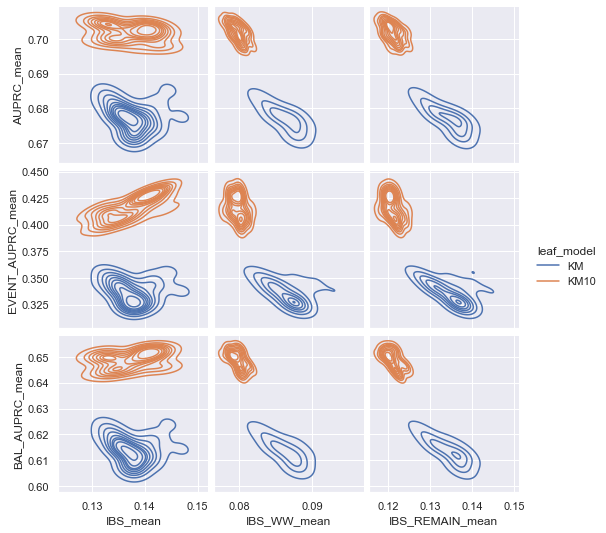

========== WUHAN ==========


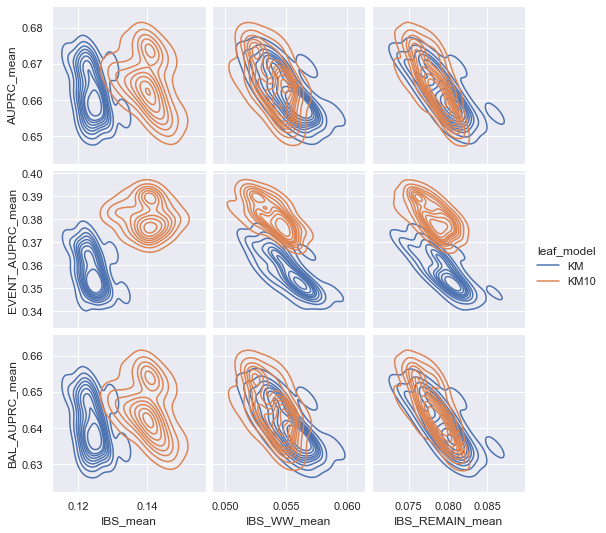

========== rott2 ==========


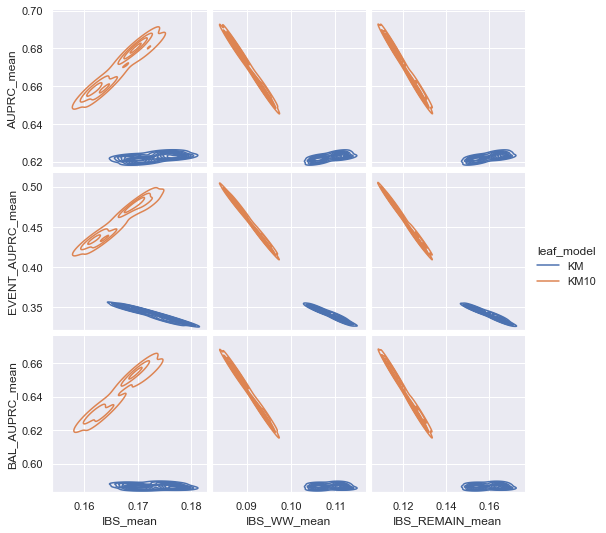

========== smarto ==========


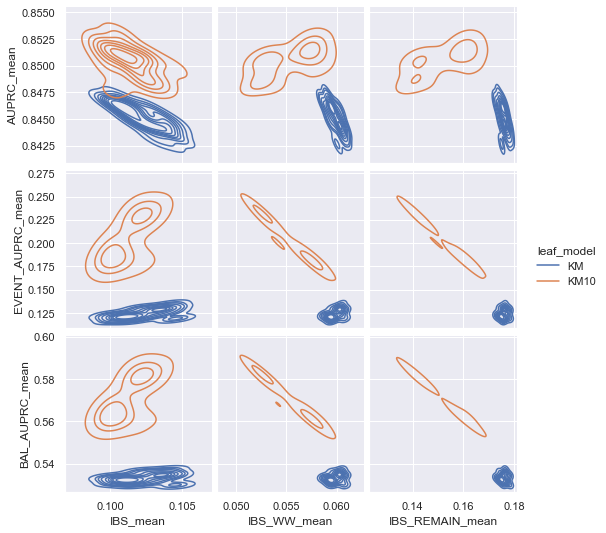

========== support2 ==========


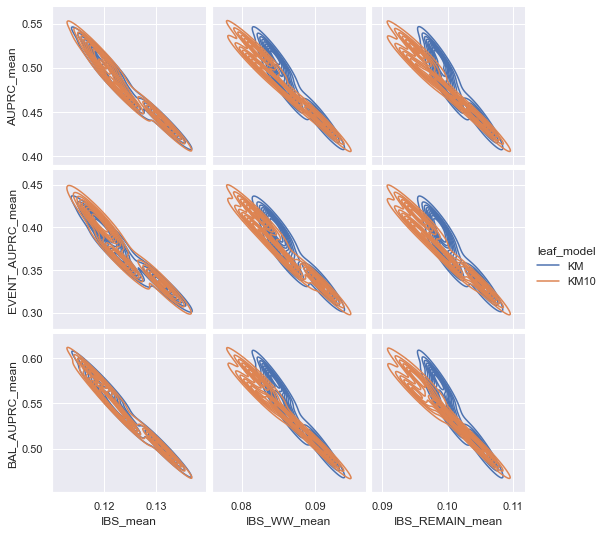

========== actg ==========


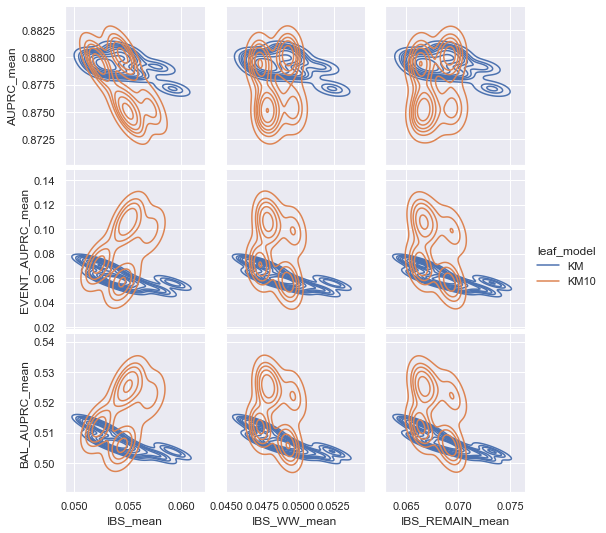

In [576]:
def pair_compare(df, strata):
#     df = df[df["PARAMS"].apply(lambda x: eval(x)["leaf_model"]=="base_zero_after")]
    df[strata] = df["PARAMS"].apply(lambda x: eval(x)[strata])
    if strata == "leaf_model":
        df[strata] = df[strata].replace(regex={'base_fast': 'KM', 'base_zero_after': 'KM10'})
    sns.pairplot(x_vars=["IBS_mean", "IBS_WW_mean", "IBS_REMAIN_mean"],
         y_vars=["AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"],
         data=df, hue=strata, palette="deep", kind="kde")
    plt.show()

def pair_compare_load(dataset, group, m, strata):
    datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
    df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
    pair_compare(df, strata)

def compare_by_m(dataset, group, ens_ms):
    lst_df = []
    for m in ens_ms:
        datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
        df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        lst_df.append(df)
    df = pd.concat(lst_df, ignore_index=True)
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x)["ens_metric_name"])
    pair_compare(df, "ens_metric_name")

for ds in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg"]:
    print("="*10, ds, "="*10)
    pair_compare_load(ds, group, "IBS_WW", 'leaf_model')
#     compare_by_m(ds, group, ["IBS", "IBS_WW", "IBS_REMAIN"])

### AUPRC

In [432]:
def auprc(survival_train, survival_test, estimate, times, axis=-1):
    time = survival_test["time"]
    event = survival_test["cens"]

    steps = np.linspace(1e-5, 1 - 1e-5, 100)
    before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
    after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
    before_ind = np.clip(np.searchsorted(times, before_time), 0, times.shape[0]-1)
    after_ind = np.clip(np.searchsorted(times, after_time), 0, times.shape[0]-1)

    est = np.take_along_axis(estimate, before_ind, axis=1)
    est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)
    
    if axis == -1:  # mean for each time and observation
        est = np.mean(est, axis=0)
        return np.trapz(est, steps)
    elif axis == 0:  # for each observation
        return np.trapz(est, steps)
    elif axis == 1:  # in time (for graphics)
        est = est.mean(axis=0)    
        return est
    elif axis == 2:  # source
        return est
    return None

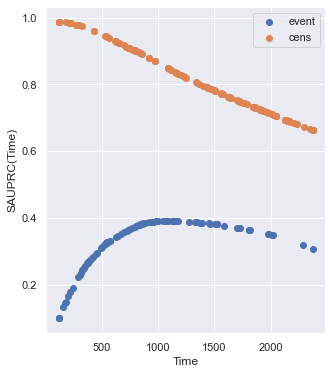

0.6021519328414829
0.33025516233960805 0.8124470912765268
0.5713511268080674


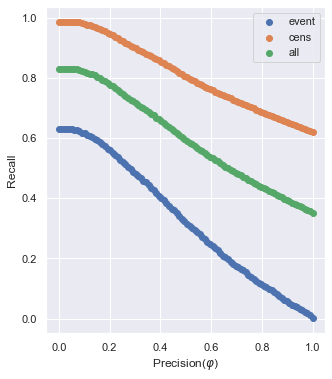

In [94]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
steps = np.linspace(1e-5, 1 - 1e-5, 100)
event = y_HO["cens"]

m_obs = auprc(None, y_HO, estimate, bins, axis=0)

plt.figure(figsize=(5, 6))
plt.scatter(y_HO[y_HO["cens"]]["time"], m_obs[event], label="event")
plt.scatter(y_HO[~y_HO["cens"]]["time"], m_obs[~event], label="cens")
plt.xlabel("Time")
plt.ylabel("SAUPRC(Time)")
plt.legend()
plt.show()

print(m_obs.mean())
print(m_obs[y_HO["cens"]].mean(), m_obs[~y_HO["cens"]].mean())
print((m_obs[y_HO["cens"]].mean() + m_obs[~y_HO["cens"]].mean())/2)

plt.figure(figsize=(5, 6))
m_src = auprc(None, y_HO, estimate, bins, axis=2)
plt.scatter(steps, m_src[y_HO["cens"]].mean(axis=0), label="event")
plt.scatter(steps, m_src[~y_HO["cens"]].mean(axis=0), label="cens")
plt.scatter(steps, m_src.mean(axis=0), label="all")
plt.xlabel(r"Precision($\varphi$)")
plt.ylabel("Recall")
plt.legend()
plt.show()

3 (True, 698.)


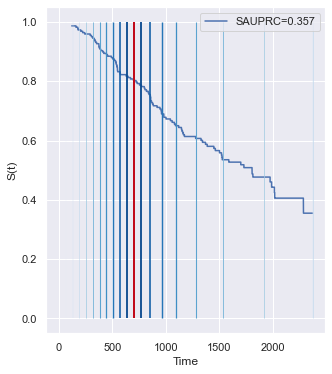

4 (True, 1807.)


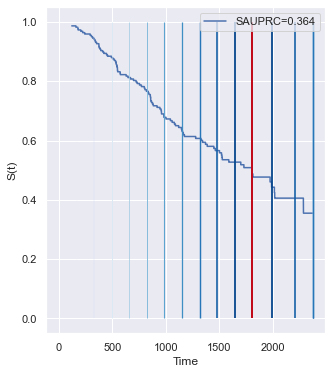

In [95]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 12)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

for i in [3, 4]:
    print(i, y_HO[i])
    plt.figure(figsize=(5, 6))
    plt.step(bins, estimate[i], label=f"SAUPRC={np.trapz(est[i], steps):.3f}")
    cmap = plt.get_cmap('Blues')
    plt.vlines(np.clip(before_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(np.clip(after_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(y_HO[i]["time"], 0, 1, colors="red")
    plt.xlabel(r"Time")
    plt.ylabel("S(t)")
    plt.legend()
    plt.show()

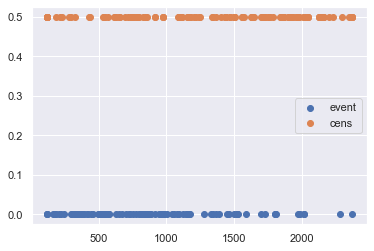

0.28193268722466963
0.0 0.49999000000000016
0.24999500000000008


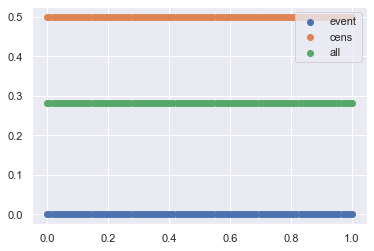

In [96]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 100)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

plt.scatter(time[event], np.trapz(est[event], steps), label="event")
plt.scatter(time[~event], np.trapz(est[~event], steps), label="cens")
plt.legend()
plt.show()
print(np.trapz(est, steps).mean())
print(np.trapz(est[event], steps).mean(), np.trapz(est[~event], steps).mean())
print((np.trapz(est[event], steps).mean() + np.trapz(est[~event], steps).mean())/2)

plt.scatter(steps, est[event].mean(axis=0), label="event")
plt.scatter(steps, est[~event].mean(axis=0), label="cens")
plt.scatter(steps, est.mean(axis=0), label="all")
plt.legend()
plt.show()

### Проверка устойчивости при калибровке

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = res_cens.append(l_cens, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = r

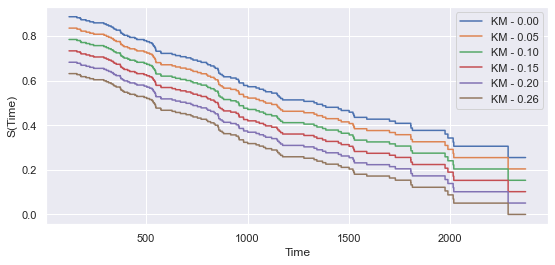

(        ibs    ibs_WW ibs_remain     auprc
 0    0.2415  0.190052   0.189927  0.330255
 1  0.223203  0.171712   0.171631  0.330255
 2  0.211377  0.158579   0.158543  0.330255
 3  0.206022  0.150653   0.150661  0.330255
 4  0.207137  0.147935   0.147987  0.330255
 5  0.214725  0.150425   0.150521  0.330255,
         ibs    ibs_WW ibs_remain     auprc
 0  0.182169  0.083251    0.08336  0.712449
 1  0.220686  0.104334   0.104465  0.661424
 2   0.26349  0.128233   0.128387  0.610399
 3  0.310579  0.154947   0.155128  0.559374
 4  0.361954  0.184477   0.184686  0.508349
 5  0.417615  0.216823   0.217062  0.457324)

In [593]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

ms = [ibs, ibs_WW, ibs_remain, auprc]
plt.figure(figsize=(9, 4))
res_event = pd.DataFrame([], columns=[m.__name__ for m in ms])
res_cens = pd.DataFrame([], columns=[m.__name__ for m in ms])

for corr_i in [a_min*i/5 for i in range(0, 6)]:
    estimate_1 = estimate - corr_i
    l_event = {}
    l_cens = {}
    for m in [ibs, ibs_WW, ibs_remain, auprc]:
        #print(m.__name__)
        m_obs = m(y_tr, y_HO, estimate_1, bins, axis=0)
        l_event[m.__name__] = m_obs[event].mean()
        l_cens[m.__name__] = m_obs[~event].mean()
        #print(f"{m_obs[event].mean():0.3f}, {m_obs[~event].mean():0.3f}")
    plt.step(bins, estimate_1[0], label = f"KM - {corr_i:0.2f}")
    res_event = res_event.append(l_event, ignore_index=True)
    res_cens = res_cens.append(l_cens, ignore_index=True)
    
plt.xlabel("Time")
plt.ylabel("S(Time)")

plt.legend()
plt.show()
res_event, res_cens

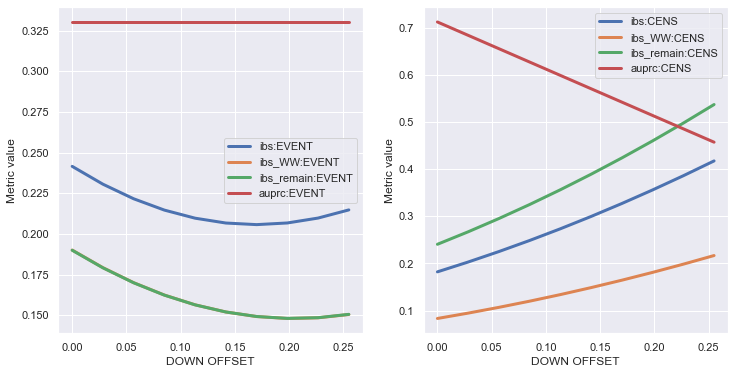

In [101]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

x = np.linspace(0, a_min, 10)  # [a_min*i/5 for i in range(0, 26)]
# plt.figure(figsize=(9, 6))
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

for m in [ibs, ibs_WW, ibs_remain, auprc]:
    # print(m.__name__)
    l_ev = []
    l_cens = []
    for corr_i in x:
        steps = np.linspace(1e-5, 1 - 1e-5, 100)
        estimate_1 = estimate - corr_i
        m_ev = m(y_tr, y_HO[event], estimate_1[event], bins, axis=-1)
        m_cens = m(y_tr, y_HO[~event], estimate_1[~event], bins, axis=-1)
        # print(f"{m_ev:.3f}, {m_cens:.3f}")
        l_ev.append(m_ev)
        l_cens.append(m_cens)
    axes[0].plot(x, l_ev, label=f"{m.__name__}:EVENT", linewidth=3)
    axes[1].plot(x, l_cens, label=f"{m.__name__}:CENS", linewidth=3)

# plt.xlabel("DOWN OFFSET")
# plt.ylabel("Metric value")
# plt.legend()
# plt.show()

axes[0].set_xlabel("DOWN OFFSET")
axes[0].set_ylabel("Metric value")
axes[0].legend()

axes[1].set_xlabel("DOWN OFFSET")
axes[1].set_ylabel("Metric value")
axes[1].legend()

plt.show()

### PLOTS OF AUPRC by event for best models

In [204]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

from survivors.ensemble import BootstrapCRAID

dataset = "flchain"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
file_name = f"shared_IBS_{dataset}_CV+SAMPLE_best.xlsx"
# file_name = f"IBS_scsurv_origin_GBSG_CV+SAMPLE_best.xlsx"

In [205]:
from survivors.experiments import grid as exp
DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "PBC": ds.load_pbc_dataset,
    "WUHAN": ds.load_wuhan_dataset,

    "actg": ds.load_actg_dataset,
    "flchain": ds.load_flchain_dataset,
    "smarto": ds.load_smarto_dataset,
    "rott2": ds.load_rott2_dataset,
    "support2": ds.load_support2_dataset,
}

def run(M_P, dataset="GBSG", except_stop="all", dir_path=None, bins_sch="", best_metric="IBS"):
    lst_metrics = ["AUPRC_by_obs"]
    X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
    experim = exp.Experiments(folds=20, except_stop=except_stop, dataset_name=dataset, mode="HOLD-OUT", bins_sch=bins_sch)
    experim.set_metrics(lst_metrics)
    experim.add_metric_best(best_metric)
    for m_p in M_P:
        m, hyp = m_p
        if m.__name__.find("CRAID") != -1:
            hyp["categ"] = [categ]
        experim.add_method(m, hyp)
    experim.run(X, y, dir_path=dir_path, verbose=1)
    return experim

M_P = []
res_table = pd.read_excel(os.path.join(glob_dir, file_name))
for i, row in res_table.iterrows():
    M_P.append((eval(row["METHOD"]), {k:[v] for k, v in eval(row["PARAMS"]).items()}))

t = run(M_P, dataset=dataset, except_stop="all", dir_path=None, bins_sch="")

<class 'sksurv.tree.tree.SurvivalTree'> {'max_depth': [None], 'max_features': ['sqrt'], 'min_samples_leaf': [10], 'random_state': [123], 'splitter': ['random']}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF SurvivalTree: 26.536501169204712 {'AUPRC_by_obs': [0.8410436330031775, array([0.99998   , 0.99998   , 0.99998   , ..., 0.97036627, 0.99998   ,
       0.99998   ])]}
<class 'sksurv.ensemble.forest.RandomSurvivalForest'> {'max_depth': [None], 'min_samples_leaf': [10], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF RandomSurvivalForest: 598.0279784202576 {'AUPRC_by_obs': [0.8492098962126275, array([0.99027821, 0.99998   , 0.99950639, ..., 0.9927835 , 0.99721632,
       0.99476048])]}
<class 'sksurv.ensemble.boosting.ComponentwiseGradientBoostingSurvivalAnalysis'> {'dropout_rate': [0.0], 'learning_rate': [0.5], 'loss': ['coxph'], 'n_estimators': [100], 'random_state': [123], 'subsample': [1.0]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF ComponentwiseGradientBoostingSurvivalAnalysis: 549.9908931255341 {'AUPRC_by_obs': [0.7629568078712722, array([0.92797951, 0.93680943, 0.93132857, ..., 0.94527488, 0.93911386,
       0.94534261])]}
<class 'sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis'> {'learning_rate': [0.1], 'loss': ['coxph'], 'max_depth': [20], 'max_features': ['sqrt'], 'min_samples_leaf': [20], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF GradientBoostingSurvivalAnalysis: 558.721467256546 {'AUPRC_by_obs': [0.8482597709394948, array([0.98434554, 0.98609408, 0.9858047 , ..., 0.98594499, 0.98523451,
       0.98678486])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.055  0.059  0.0579 0.0546 0.0519 0.0523 0.0509 0.05   0.0488 0.0476
 0.0475 0.0466 0.0461 0.0457 0.0456 0.0455 0.0453 0.045  0.0448 0.0445
 0.0444 0.0442 0.044  0.0442 0.0441 0.0441 0.044  0.044  0.0439 0.0439
 0.0438 0.0438 0.0438 0.0438 0.0438 0.0439 0.0438 0.0439 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0437 0.0437 0.0437 0.0436 0.0436 0.0437 0.0436]
fitted: 47 models.
[0.055  0.0524 0.0572 0.0535 0.0519 0.0513 0.0496 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3062.613472223282 {'AUPRC_by_obs': [0.8529618287367722, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0541 0.0544 0.0568 0.0536 0.0521 0.0519 0.0507 0.0495 0.0489 0.0478
 0.0473 0.0465 0.0459 0.0456 0.0455 0.0456 0.0453 0.0451 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.0441 0.0441
 0.044  0.0441 0.0441 0.044  0.044  0.044  0.0439 0.044  0.044  0.044
 0.044  0.044  0.044  0.044  0.0439 0.0439 0.0438 0.0439 0.0439 0.0438]
fitted: 47 models.
[0.0538 0.0518 0.0546 0.0516 0.0503 0.0502 0.0492 0.0484 0.0476 0.0465
 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3087.8225588798523 {'AUPRC_by_obs': [0.8528430834295823, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0521 0.0591 0.057  0.0533 0.0516 0.0514 0.0504 0.0496 0.0491 0.048
 0.0478 0.047  0.0466 0.0462 0.046  0.046  0.0456 0.0453 0.0451 0.0448
 0.0445 0.0444 0.0443 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.044
 0.0439 0.044  0.044  0.0439 0.0439 0.0439 0.0438 0.0438 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0439 0.0438 0.0438 0.0438 0.0438 0.0438 0.0438]
fitted: 37 models.
[0.0557 0.0538 0.0567 0.0527 0.0514 0.0508 0.0493 0.0489 0.0477 0.

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3044.9547975063324 {'AUPRC_by_obs': [0.8525744422548376, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0516 0.0582 0.0589 0.0559 0.0537 0.0536 0.0517 0.0504 0.0494 0.0483
 0.0479 0.047  0.0465 0.0462 0.046  0.046  0.0458 0.0456 0.0453 0.0451
 0.0449 0.0447 0.0446 0.0447 0.0445 0.0444 0.0444 0.0443 0.0444 0.0443
 0.0443 0.0442 0.0442 0.0442 0.0442 0.0441 0.044  0.044  0.0441 0.044
 0.0441 0.044  0.044  0.0441 0.044  0.0439 0.0439 0.0439 0.0439 0.0439]
fitted: 46 models.
[0.0552 0.0524 0.055  0.0519 0.0504 0.0503 0.0494 0.0484 0.0476 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3095.867123603821 {'AUPRC_by_obs': [0.852767483547439, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0535 0.0535 0.0587 0.0546 0.0521 0.0518 0.0502 0.0493 0.0485 0.048
 0.0476 0.0469 0.0465 0.0459 0.0458 0.0457 0.0455 0.0452 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0442 0.0442 0.0442 0.0442 0.0442
 0.0441 0.044  0.0441 0.0441 0.0441 0.0441 0.044  0.0439 0.044  0.0439
 0.044  0.0439 0.0439 0.0439 0.0439 0.0438 0.0438 0.0438 0.0437 0.0438]
fitted: 49 models.
[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3136.073700428009 {'AUPRC_by_obs': [0.85312792182898, array([0.96698485, 0.99998   , 0.99765281, ..., 0.9901416 , 0.99930733,
       0.99427001])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0508 0.0542 0.053  0.0502 0.0479 0.0483 0.0471 0.0464 0.0453 0.0442
 0.0441 0.0434 0.0429 0.0426 0.0424 0.0424 0.0422 0.0419 0.0417 0.0414
 0.0413 0.0411 0.041  0.0411 0.0411 0.0411 0.041  0.0409 0.0409 0.0409
 0.0408 0.0408 0.0408 0.0408 0.0408 0.0409 0.0408 0.0409 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0408 0.0407 0.0407 0.0407 0.0407 0.0407 0.0406]
fitted: 50 models.
[0.0507 0.0484 0.0528 0.0495 0.0481 0.0477 0.0461 0.0453 0.0445 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.8954479694366 {'AUPRC_by_obs': [0.8529773575149493, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0501 0.0501 0.0521 0.0493 0.0481 0.0479 0.047  0.0459 0.0453 0.0443
 0.0439 0.0432 0.0427 0.0424 0.0423 0.0423 0.0421 0.0419 0.0418 0.0416
 0.0414 0.0413 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.041  0.041
 0.041  0.041  0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0408 0.0408 0.0409 0.0408 0.0408]
fitted: 46 models.
[0.0496 0.0478 0.0507 0.048  0.0468 0.0467 0.0459 0.0451 0.0443 0.043

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3239.9646191596985 {'AUPRC_by_obs': [0.8528274073021267, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0482 0.0546 0.0526 0.0492 0.0478 0.0476 0.0467 0.046  0.0456 0.0446
 0.0444 0.0437 0.0433 0.043  0.0428 0.0428 0.0425 0.0422 0.0419 0.0417
 0.0414 0.0413 0.0412 0.0413 0.0412 0.0411 0.041  0.041  0.041  0.0409
 0.0408 0.0409 0.0409 0.0409 0.0408 0.0409 0.0408 0.0408 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0409 0.0408 0.0408 0.0408 0.0408 0.0408 0.0408]
fitted: 31 models.
[0.0509 0.0494 0.052  0.0486 0.0475 0.047  0.0458 0.0454 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.5338521003723 {'AUPRC_by_obs': [0.8526692642134172, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0475 0.0536 0.0541 0.0515 0.0495 0.0495 0.0478 0.0467 0.0459 0.0448
 0.0445 0.0437 0.0433 0.043  0.0428 0.0429 0.0427 0.0425 0.0422 0.042
 0.0418 0.0417 0.0415 0.0416 0.0415 0.0413 0.0414 0.0413 0.0413 0.0413
 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.0409 0.041  0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.0409 0.0409 0.0409 0.0408]
fitted: 50 models.
[0.051  0.0485 0.0511 0.0482 0.0469 0.0469 0.046  0.0451 0.0444 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3311.712080001831 {'AUPRC_by_obs': [0.852772250365599, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0495 0.0494 0.0536 0.0501 0.0479 0.0478 0.0466 0.0457 0.0449 0.0446
 0.0442 0.0436 0.0432 0.0427 0.0426 0.0425 0.0423 0.042  0.0418 0.0416
 0.0415 0.0413 0.0412 0.0413 0.0412 0.0411 0.0412 0.0412 0.0411 0.0411
 0.041  0.041  0.041  0.0411 0.0411 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.0409 0.0409 0.0408 0.0408 0.0408 0.0407 0.0408]
fitted: 49 models.
[0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


In [214]:
t.result_table

,METHOD,PARAMS,TIME,AUPRC_by_obs,CRIT,AUPRC_by_obs_mean
0,SurvivalTree,"{'max_depth': None, 'max_features': 'sqrt', 'm...",26.536501,"[[0.5088726201715644, 0.99998, 0.5870753453453...",,0.841763
1,RandomSurvivalForest,"{'max_depth': None, 'min_samples_leaf': 10, 'n...",598.027978,"[[0.5775316032673518, 0.9984690874579123, 0.61...",,0.849242
2,ComponentwiseGradientBoostingSurvivalAnalysis,"{'dropout_rate': 0.0, 'learning_rate': 0.5, 'l...",549.990893,"[[0.26845801074103914, 0.9517472556548336, 0.5...",,0.762902
3,GradientBoostingSurvivalAnalysis,"{'learning_rate': 0.1, 'loss': 'coxph', 'max_d...",558.721467,"[[0.575600266823277, 0.9890737005552414, 0.608...",,0.848339
4,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3062.613472,"[[0.5578023124817755, 0.9988172125624866, 0.60...",maxcombo,0.853027
5,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3087.822559,"[[0.5927989167171015, 0.9993806030520384, 0.62...",peto,0.852886
6,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3044.954798,"[[0.5896413405463207, 0.9986480448251204, 0.61...",tarone-ware,0.852602
7,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3095.867124,"[[0.5859008998298434, 0.9992946355518292, 0.60...",wilcoxon,0.852790
8,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3136.0737,"[[0.608182694727038, 0.9969248132351506, 0.609...",logrank,0.853161
9,BootstrapCRAID,"{'balance': None, 'categ': ['fac_sex', 'fac_ch...",3231.895448,"[[0.5521927484093636, 0.9988869798087374, 0.61...",maxcombo,0.853042


In [215]:
X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    break

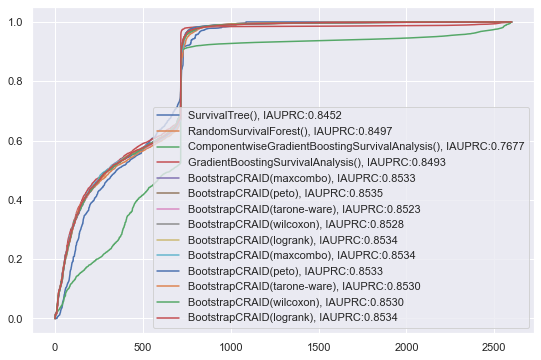

In [217]:
# def integ_by_obs_auprc(times_, auprc_):
#     ind = np.argsort(times_)
#     return np.trapz(auprc_[ind], times_[ind])/(np.max(times_) - np.min(times_))

def integ_by_obs_auprc(times_, auprc_):
    utimes = np.unique(times_)
    ind = np.digitize(times_, utimes) - 1
    return np.trapz(np.bincount(ind, weights=auprc_[ind])/np.bincount(ind), utimes)/(np.max(times_) - np.min(times_))

# plt.figure(figsize=(9, 6))
# for i, row in t.result_table.iterrows():
#     plt.scatter(y_test["time"], row["AUPRC_by_obs"][0], 
# #                 label=f"{row['METHOD']} (INTEGR:{row['AUPRC_by_obs'][0][y_test['cens']].mean():.4f})")
#                 label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
# plt.legend()

plt.figure(figsize=(9, 6))
for i, row in t.result_table.iterrows():
    ind = np.argsort(row["AUPRC_by_obs"][0])
    plt.plot(row["AUPRC_by_obs"][0][ind], 
             label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
plt.legend()

In [203]:
save_path = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/AUPRC_by_obs/"
t.result_table.to_excel(os.path.join(save_path, f"AUPRC_by_obs_{dataset}.xlsx"), index=False)

In [63]:
import pickle

# name = "D:\\Vasilev\\SA\\actg\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.05_50_5_1.0_HOLD-OUT_0.pkl"
name = "D:\\Vasilev\\SA\\flchain\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.001_50_5_1.0_HOLD-OUT_1.pkl"

with open(name, 'rb') as inp:
    est = pickle.load(inp)
    est.tolerance_find_best("IBS")

[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
 0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
 0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
 0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
fitted: 49 models.


In [62]:
# IBS_WW
# [0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0435
#  0.0437 0.0435 0.043  0.0428 0.0425 0.0423 0.0422 0.042  0.0418 0.0417
#  0.0415 0.0414 0.0413 0.0412 0.0411 0.041  0.041  0.0409 0.0409 0.0408
#  0.0408 0.0407 0.0407 0.0407 0.0407 0.0406 0.0407 0.0406 0.0406 0.0406
#  0.0407 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0405]
# fitted: 50 models.

print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

50
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C719463B0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

In [64]:
# IBS
# [0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
#  0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
#  0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
#  0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
#  0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
# fitted: 49 models.
    
print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

49
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C712A5BD0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

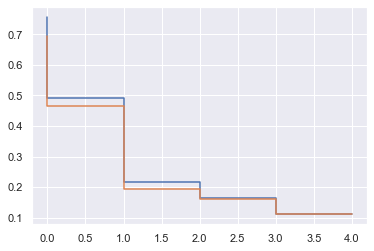

In [81]:
hf1 = np.array([0.05, 0.1, 0.8, 0.05, 0.05])*2
hf2 = np.array([0.5, 0, 0.5, 0.0, 0])*2
hf3 = np.array([0.0, 0.5, 0.0, 0.25, 0.5])*2

chf1 = np.cumsum(hf1)
chf2 = np.cumsum(hf2)
chf3 = np.cumsum(hf3)

plt.step(np.arange(5), (np.exp(-chf1) + np.exp(-chf2) + np.exp(-chf3))/3)
plt.step(np.arange(5), (np.exp(-(chf1 + chf2 + chf3)/3)))

In [93]:
def get_comb_fast(df, features):
    info = {}
    X = df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T

    def create_params_f(v_feature, name):
        d = info.copy()
        d["arr"] = np.vstack((v_feature, X[-2:]))
        return d

    return list(map(create_params_f, X[:-2], features))

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X[cnt.TIME_NAME] = y[cnt.TIME_NAME]

%timeit get_comb_fast(X, features)

561 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Demonstartion of convergence error of COXPH on flchain

In [ ]:
# Method: CoxPHSurvivalAnalysis, Param: {'alpha': 100, 'ties': 'breslow'} finished with except 'search direction contains NaN or infinite values'
        
from survivors.experiments import grid as exp
from sksurv.linear_model import CoxPHSurvivalAnalysis

X, y, features, categ, sch_nan = ds.load_flchain_dataset()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    X_train = X_train.fillna(0).replace(np.nan, 0)
    X_test = X_test.fillna(0).replace(np.nan, 0)

    cmodel = CoxPHSurvivalAnalysis(alpha=100, ties='breslow')
    cmodel = cmodel.fit(X_train, y_train)
    
    survs = cmodel.predict_survival_function(X_test)
    hazards = cmodel.predict_cumulative_hazard_function(X_test)
    pred_surv = np.array(list(map(lambda x: x(bins), survs)))
    
    # constant prediction
    # print(pred_surv)

### Tree coefficient analysis

In [177]:
def eq_coeff(v):
    return np.ones_like(v)*1/v.shape[0]

def min_coeff(v):
    return np.where(v == v.min(), 1, 0)

def clever_coeff(v):
    s = (1/v).sum()
    return 1/v*1/s

def lin_coeff(v):
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def sqr_coeff(v):
    v = v**2
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def exp_coeff(v):
    v = 1 - np.exp(-v)
    beta = v/(1-v)
    w = 1/beta # np.log(1/beta)
    return w/np.sum(w)

def target_function(v, coeff):
    return coeff.shape[0]*((coeff**2)*v).sum()

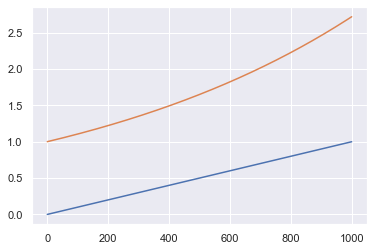

In [182]:
x = np.linspace(0.001, 1, 1000)
plt.plot(x)
plt.plot(np.exp(x))

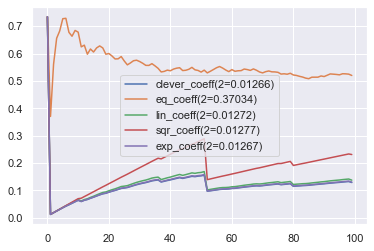

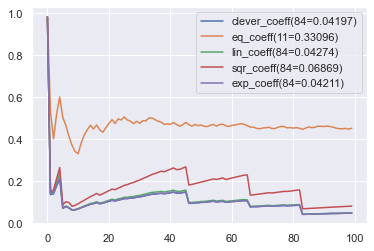

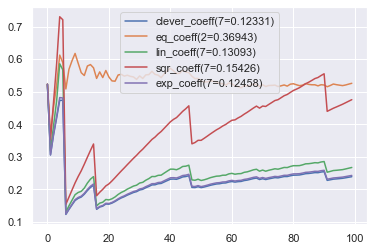

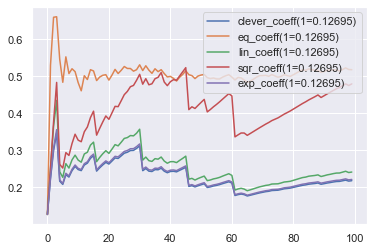

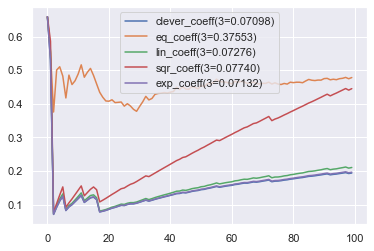

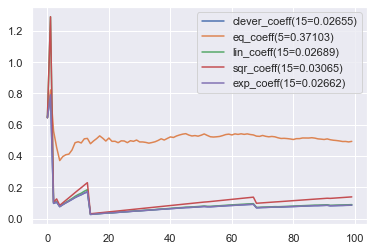

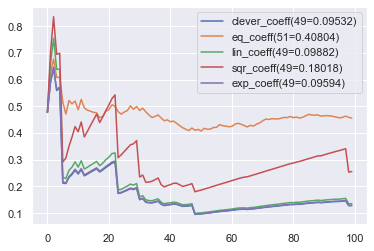

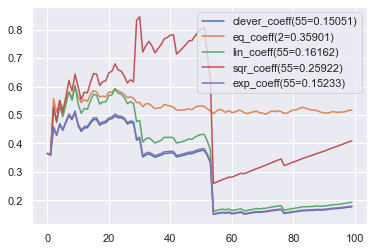

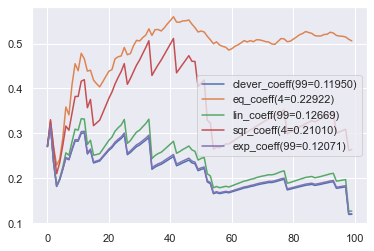

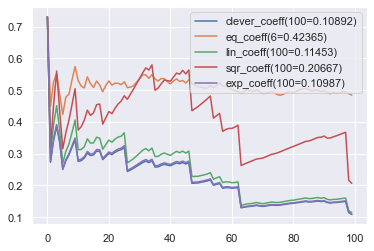

In [178]:
size = 100
for i in range(10):
    v = np.random.rand(size)
    # v = np.linspace(0.01, 0.99, size) # increace
    # v = np.linspace(0.99, 0.01, size)**2 # decreace
    # v = np.hstack([np.linspace(0.99, 0.01, size//2), np.linspace(0.01, 0.99, size//2)]) # decreace

    d = {}
    for f_coeff in [clever_coeff, eq_coeff, lin_coeff, sqr_coeff, exp_coeff]:
        f_l = [target_function(v[:i], f_coeff(v[:i])) for i in range(1, size+1)]
        d[f_coeff.__name__] = np.array(f_l)
        assert (d[f_coeff.__name__] >= d[clever_coeff.__name__]).all()

        
        plt.plot(f_l, label=f"{f_coeff.__name__}({np.argmin(f_l)+1}={np.min(f_l):.5f})")
    plt.legend()
    plt.show()

eq_coeff 6 0.32536369916165403 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32471069338355446 0.0194515296580345
clever_coeff 6 0.32395696955774045 [0.14514848 0.17194642 0.16892933 0.172576   0.16358176 0.17781801]
0.32333946190572477 0.019667833420237295


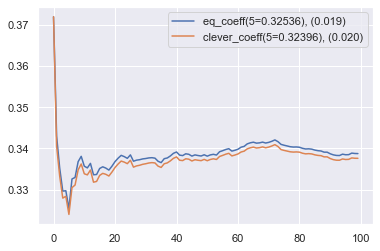

In [156]:
# np.random.seed(42)
bins = np.linspace(1, 1000, 100)
tf = cnt.get_y(np.array([bins.mean()]), np.array([True]))
ibs_l = []
auprc_l = []
sf_l = []
for i in range(100):
    s = np.random.rand(100)
    sf = np.cumsum((s/np.sum(s))[::-1])[::-1][np.newaxis, :]
    sf_l.append(sf)
    ibs_l.append(metr.ibs_WW(tf, tf, sf, bins))

ibs_l = np.array(ibs_l)
sf_l = np.vstack(sf_l)
d = {}
for f_coeff in [eq_coeff, clever_coeff]:
    L = [target_function(ibs_l[:i], f_coeff(ibs_l[:i])) for i in range(1, 101)]
    best_i = np.argmin(L) + 1
    print(f_coeff.__name__, best_i, np.min(L), f_coeff(ibs_l[:best_i]))
    fin_ibs = metr.ibs_WW(tf, tf, np.dot(sf_l[:best_i].T, f_coeff(ibs_l[:best_i]))[np.newaxis, :], bins)
    fin_auprc = metr.auprc(tf, tf, np.dot(sf_l[:best_i].T, f_coeff(ibs_l[:best_i]))[np.newaxis, :], bins)
    print(fin_ibs, fin_auprc)
    assert fin_ibs <= np.min(L)

    plt.plot(L, label=f"{f_coeff.__name__}({np.argmin(L)}={np.min(L):.5f}), ({fin_auprc:.3f})")
plt.legend()

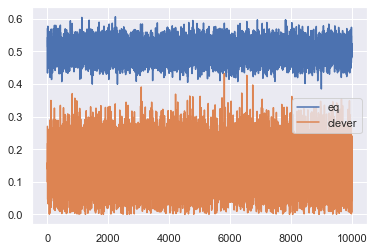

In [157]:
e_l = []
m_l = []
c_l = []

for i in range(10000):
    v = np.random.rand(100)
    e_c = target_function(v, eq_coeff(v))
    m_c = target_function(v, min_coeff(v))
    c_c = target_function(v, clever_coeff(v))
    e_l.append(e_c)
    m_l.append(m_c)
    c_l.append(c_c)
#     print(f'e_c:{e_c:.5f}, m_c:{m_c:.5f}, c_c:{c_c:.5f}')
    assert e_c > c_c
    assert m_c > c_c

# plt.plot(m_l, label="min")
plt.plot(e_l, label="eq")
plt.plot(c_l, label="clever")
plt.legend()

In [10]:
v = np.array([0.05, 0.01, 0.04])
target_function(v, eq_coeff(v))

0.06666666666666667

In [11]:
target_function(v, min_coeff(v))

0.06

In [12]:
target_function(v, clever_coeff(v))

0.04137931034482759

### IBS BOOSTING clever

In [2]:
from survivors.tree import CRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None
        
    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        sf = self.predict_at_times(X, self.bins, mode="surv")
        ibs_v = metr.ibs_WW(y, y, sf, self.bins, axis=0)

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
        self.ibs_leaf[counts>0]/=counts[counts>0]
        self.ibs_leaf += 1e-5
    
    def get_ibs_by_leaf(self, X, divide=False):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]
    
    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)

In [3]:
from survivors.ensemble import BoostingCRAID
from scipy.stats import norm

class IBSCleverBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()
        
        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
#             print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
    
    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
        m = metr.ibs_WW
        wei = m(self.y_train, y_sub, pred_sf, self.bins, axis=0) + 1e-5
        return wei, np.mean(wei)
    
    def update_weight(self, index, wei_i):
        if len(self.models) > 1:
            self.weights = 1/(1/self.weights + 1/wei_i)
        else:
            self.weights = wei_i

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            wei = 1/wei*(1/np.sum(1/wei, axis=1)).reshape(-1, 1)
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)
    
    def tolerance_find_best(self, ens_metric_name="bic"):
        pass

In [4]:
a1 = np.bincount(np.array([0, 0, 0, 0]))
a2 = np.bincount(np.array([0, 0, 0, 0]), weights=np.array([0.0, 0.0, 0.0, 0.0]))
a2[a1 > 0] /= a1[a1 > 0]
a2 + 1e-15

array([1.e-15])

In [8]:
tree_m = IBSCRAID()
tree_m.fit(X_train.iloc[[0]*7,:], y_train[[0]*7])
tree_m.ibs_leaf

numbs = tree_m.predict(X_train.iloc[[0]*7,:], target="numb").astype("int")
sf = tree_m.predict_at_times(X_train.iloc[[0]*7,:], tree_m.bins, mode="surv")
ibs_v = metr.ibs_WW(y_train[[0]*7], y_train[[0]*7], sf, tree_m.bins, axis=0)

counts = np.bincount(numbs)
ibs_leaf = np.bincount(numbs, weights=ibs_v)
ibs_leaf[counts > 0] /= counts[counts > 0]
ibs_leaf

array([nan])

In [9]:
import sksurv.metrics
def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

In [103]:
from survivors.tree import CRAID
from survivors.ensemble import BoostingCRAID

# class IBSCRAID(CRAID):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.ibs_leaf = None

#     def set_ibs_by_leaf(self, X, y):
#         numbs = self.predict(X, target="numb").astype("int")
#         sf = self.predict_at_times(X, self.bins, mode="surv")
#         ibs_v = ibs_WW(y, y, sf, self.bins, axis=0)

#         counts = np.bincount(numbs)
#         self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
#         self.ibs_leaf[counts > 0] /= counts[counts > 0]
#         self.ibs_leaf += 1e-3

#     def get_ibs_by_leaf(self, X, divide=False):
#         numbs = self.predict(X, target="numb").astype("int")
#         return self.ibs_leaf[numbs]

#     def fit(self, X, y):
#         super().fit(X, y)
#         self.set_ibs_by_leaf(X, y)
        
class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None

    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        
        sf = self.predict_at_times(X, bins=self.bins, mode="surv")
        
#         time_diff = self.bins[-1] - self.bins[0] if self.bins[-1] > self.bins[0] else 1
#         ibs_ex = 1/time_diff* np.trapz(np.where(sf > 0.5, 
#                    (1 - sf)**2, (sf)**2), self.bins, axis=1)
#         ibs_ex = metr.ibs_WW(y, y, sf, self.bins, axis=0)
#         tm = self.predict(X, target="time")
        tm = np.trapz(sf, self.bins, axis=1)
        ev = self.predict(X, target="cens")
        
        y_ = cnt.get_y(time=tm, cens=ev)
        y_["cens"] = True
        ibs_ev = metr.ibs_WW(y_, y_, sf, self.bins, axis=0)
        
        y_["cens"] = False
        ibs_cn = metr.ibs_WW(y_, y_, sf, self.bins, axis=0)
        
        ibs_ex = ibs_ev*ev + ibs_cn*(1-ev)
#         print(tm[:5], ev[:5], sf[:5])
#         print(ibs_ev[:5], ibs_cn[:5], ibs_ex[:5])

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_ex)
        self.ibs_leaf[counts > 0] /= counts[counts > 0]
        self.ibs_leaf += 1e-15
        
#         self.ibs_leaf[:] = 1

    def get_ibs_by_leaf(self, X):
        numbs = self.predict(X, target="numb").astype("int")
        return self.ibs_leaf[numbs]

    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)


class IBSCleverBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print("UNIQUE:", np.unique(x_sub.index).shape[0])
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))
            weights.append(self.models[i].get_ibs_by_leaf(x_test))

        res = np.array(res)
        weights = np.vstack(weights).T
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        #         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
        m = metr.ibs_WW
        wei = m(self.y_train, y_sub, pred_sf, self.bins, axis=0) + 1e-15
#         wei = model.get_ibs_by_leaf(X_sub)
        return wei, np.mean(wei)

    def update_weight(self, index, wei_i):
#         if len(self.models) > 1:
#             self.weights = 1 / (1 / self.weights + 1 / wei_i)
#         else:
#             self.weights = wei_i
        if len(self.models) > 1:
            self.weights += wei_i
        else:
            self.weights = wei_i

#         plt.scatter(self.y_train["time"], wei_i)
#         plt.scatter(self.y_train["time"], self.weights)
#         plt.show()

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
#             wei = 1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1)
#             print(1, (1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1))[:3])
            arr = 1/wei
            L = np.arange(1, wei.shape[1]+1)/np.cumsum(arr, axis=1)
            best_L = np.argmin(L, axis=1)

            a_ = np.ones_like(arr)*np.arange(wei.shape[1])
            a_ = np.where(a_ <= best_L.reshape((-1, 1)), arr, 0)
            wei = a_/np.sum(a_, axis=1).reshape(-1, 1)
#             print(2, wei[:3])
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def tolerance_find_best(self, ens_metric_name="bic"):
        pass

In [80]:
# wei = np.array([[0.1, 0.05, 0.07], [0.01, 0.5, 0.001]])
# arr = 1/wei
# L = np.arange(1, wei.shape[1]+1)/np.cumsum(arr, axis=1)
# best_L = np.argmin(L, axis=1)

# a_ = np.ones_like(arr)*np.arange(wei.shape[1])
# a_ = np.where(a_ <= best_L.reshape((-1, 1)), arr, 0)
# a_ = a_/np.sum(a_, axis=1).reshape(-1, 1)
# a_, best_L

In [21]:
#param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
#         'criterion': 'peto', 'depth': 15, 'ens_metric_name': 'ibs_WW', 'max_features': 'sqrt',
#         'min_samples_leaf': 10, 'n_estimators': 5, 'size_sample': 0.5, 
#         "leaf_model": "base_fast", "all_weight": True}

from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

# param = {'aggreg_func': 'wei', 'categ': categ,
#          'all_weight': True, 'balance': None, 'criterion': 'maxcombo', 
#          'depth': 10, 'ens_metric_name': 'IBS', 'leaf_model': 'base_zero_after', 
#          'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'n_estimators': 10, 
#          'n_jobs': 5, 'size_sample': 0.7}
param = {'aggreg_func': 'wei', 'balance': None, 'categ': categ, 'all_weight': True, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
        'n_estimators': 10, 'n_jobs': 5, 'size_sample': 0.7}

# param = {'aggreg_func': 'wei', 'all_weight': True, 'balance': None, 'categ': categ, 
#  'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 'leaf_model': 'base_zero_after', 
#  'max_features': 0.3, 'min_samples_leaf': 0.05, 'n_estimators': 50, 'n_jobs': 5, 'size_sample': 1.0}

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

metr_lst = []
for X_train, y_train, X_test, y_test, bins in generate_sample(X_tr, y_tr, 5, "CV"):
    bst = IBSCleverBoostingCRAID(**param)
    bst.fit(X_train, y_train)
    bst.tolerance_find_best(param["ens_metric_name"])
    
    pred_surv = bst.predict_at_times(X_test, bins=bins, mode="surv")
    pred_time = bst.predict(X_test, target=cnt.TIME_NAME)
    pred_haz = bst.predict_at_times(X_test, bins=bins, mode="hazard")
    metr_lst.append(count_metric(y_train, y_test, pred_time,
                        pred_surv, pred_haz, bins, ['CI', "IBS_WW", "AUPRC"]))
print(np.mean(np.vstack(metr_lst), axis=0))

UNIQUE: 186
UNIQUE: 167
UNIQUE: 173
UNIQUE: 184
UNIQUE: 182
UNIQUE: 178
UNIQUE: 182
UNIQUE: 192
UNIQUE: 184
UNIQUE: 178
UNIQUE: 186
UNIQUE: 166
UNIQUE: 178



KeyboardInterrupt



In [81]:
# [0.62227902 0.12023576 0.64451712] (50 bstr)
# [0.59331976 0.13996283 0.65503329] (10 bstr + wei min ibs + 1e-2)
# [0.58974226 0.14377443 0.65572951] (10 bstr + wei mean ibs + 1e-2)
# [0.60158347 0.14604332 0.66555133] (10 bstr + wei ibs(ET) + 1e-2)
# [0.6002758  0.14026429 0.65347367] (10 bstr + wei ibs(mean time) + 1e-2)

# [0.58567914 0.13969754 0.64724877] (10 boost + wei min ibs + 1e-2)
# [0.57812389 0.14612808 0.64278387] (10 boost + wei mean ibs + 1e-2)
# [0.5835159  0.14140395 0.65858611] (10 boost + wei ibs(ET) + 1e-2)
# [0.58466947 0.14592579 0.63839241] (10 boost + wei ibs(mean time) + 1e-2)

In [104]:
param = {'aggreg_func': 'wei', 'balance': None, 'categ': categ, 'all_weight': True, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bst = IBSCleverBoostingCRAID(**param)
bst.fit(X_tr, y_tr)
bst.tolerance_find_best(param["ens_metric_name"])

pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_time = bst.predict(X_HO, target=cnt.TIME_NAME)
pred_haz = bst.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, ['CI', "IBS_WW", "AUPRC"]))

UNIQUE: 231
UNIQUE: 150
UNIQUE: 202
UNIQUE: 208
UNIQUE: 200
UNIQUE: 200
UNIQUE: 201
UNIQUE: 207
UNIQUE: 210
UNIQUE: 209
UNIQUE: 205
UNIQUE: 221
UNIQUE: 210
UNIQUE: 202
UNIQUE: 213
UNIQUE: 223
UNIQUE: 217
UNIQUE: 208
UNIQUE: 214
UNIQUE: 199
UNIQUE: 209
UNIQUE: 204
UNIQUE: 211
UNIQUE: 214
UNIQUE: 221
UNIQUE: 219
UNIQUE: 209
UNIQUE: 214
UNIQUE: 208
UNIQUE: 205
UNIQUE: 210
UNIQUE: 207
UNIQUE: 206
UNIQUE: 215
UNIQUE: 223
UNIQUE: 216
UNIQUE: 203
UNIQUE: 218
UNIQUE: 223
UNIQUE: 211
UNIQUE: 216
UNIQUE: 213
UNIQUE: 216
UNIQUE: 224
UNIQUE: 218
UNIQUE: 211
UNIQUE: 214
UNIQUE: 209
UNIQUE: 215
UNIQUE: 221
[0.48252883 0.05373002 0.92422394]


In [105]:
# [0.62368575 0.10562563 0.66351776] (50 bstr)
# [0.60777799 0.12378968 0.68154613] (10 bstr + wei min ibs + 1e-2)
# [0.60273598 0.12637439 0.68327403] (10 bstr + wei mean ibs + 1e-2)
# [0.60601915 0.12603678 0.69102384] (10 bstr + wei ibs(ET) + 1e-2)
# [0.60601915 0.12474707 0.67894255] (10 bstr + wei ibs(mean time) + 1e-2)

# [0.6013289  0.12139948 0.67901774] (10 boost + wei min ibs + 1e-2)
# [0.58692593 0.11979066 0.67487723] (10 boost + wei mean ibs + 1e-2)
# [0.59536838 0.12692    0.67587691] (10 boost + wei ibs(ET) + 1e-2)
# [0.56896619 0.12403385 0.67334499] (10 boost + wei ibs(mean time) + 1e-2)

In [106]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.001, 
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}

bstr = BootstrapCRAID(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param["ens_metric_name"])

fitted: 50 models.
[0.2597 0.2239 0.2042 0.2024 0.194  0.1913 0.1919 0.1879 0.1811 0.1788
 0.1778 0.1751 0.1749 0.1722 0.1732 0.1717 0.1718 0.1711 0.1695 0.1691
 0.1688 0.1675 0.1687 0.1679 0.1672 0.1667 0.1666 0.1659 0.1656 0.165
 0.1644 0.1641 0.164  0.1637 0.1638 0.1637 0.1629 0.1632 0.1626 0.1627
 0.1625 0.1623 0.1622 0.1615 0.1618 0.1616 0.1609 0.1611 0.1607 0.1606]
fitted: 50 models.


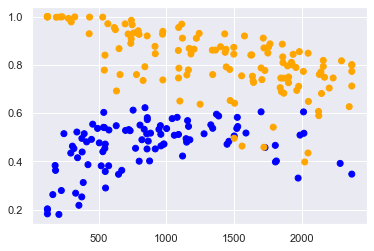

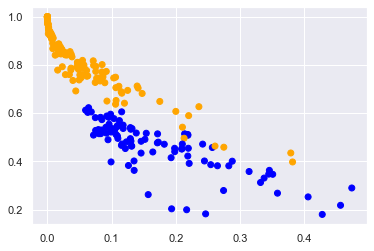

0.6635177575926148
0.10562562715862804
0.6816191229203428
0.08652165789254485


In [115]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

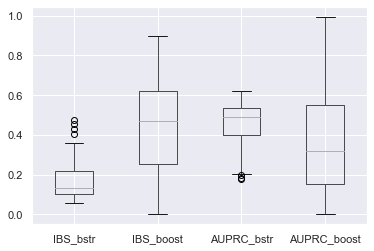

In [129]:
df = pd.DataFrame([])
df["IBS_bstr"] = metr.ibs_WW(y_tr, y_HO[y_HO["cens"]], pred_surv_bstr[y_HO["cens"]], bins_HO, axis=0)
df["IBS_boost"] = metr.ibs_WW(y_tr, y_HO[y_HO["cens"]], pred_surv[y_HO["cens"]], bins_HO, axis=0)

# data1 = np.vstack([metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0),
#                   metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)]).T

# data2 = np.vstack([metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0),
#                   metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)]).T

df["AUPRC_bstr"] = metr.auprc(y_tr, y_HO[y_HO["cens"]], pred_surv_bstr[y_HO["cens"]], bins_HO, axis=0)
df["AUPRC_boost"] = metr.auprc(y_tr, y_HO[y_HO["cens"]], pred_surv[y_HO["cens"]], bins_HO, axis=0)

df.boxplot();
plt.show()

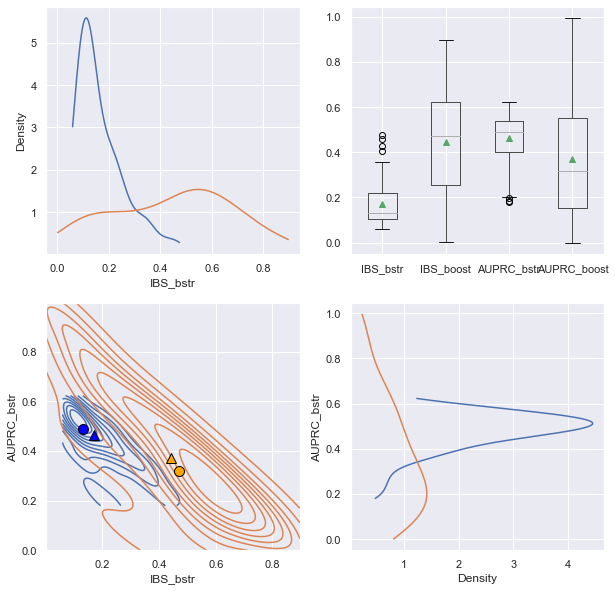

In [130]:
# sns.kdeplot(x=data1.T[0], y=data2.T[0], label="bstr")
# sns.kdeplot(x=data1.T[1], y=data2.T[1], label="boost")

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
t = sns.kdeplot(data=df, x="IBS_bstr", y="AUPRC_bstr", ax=axes[1,0], cut=0)
sns.kdeplot(data=df, x="IBS_boost", y="AUPRC_boost", ax=axes[1,0], cut=0)

sns.kdeplot(data=df, x="IBS_bstr", ax=axes[0,0], cut=0)
sns.kdeplot(data=df, x="IBS_boost", ax=axes[0,0], cut=0)

sns.kdeplot(data=df, y="AUPRC_bstr", ax=axes[1,1], cut=0)
sns.kdeplot(data=df, y="AUPRC_boost", ax=axes[1,1], cut=0)

df.boxplot(ax=axes[0,1], showmeans=True) # , vert=False)

axes[1,0].plot(df["IBS_bstr"].mean(), df["AUPRC_bstr"].mean(), '^', color='blue', ms=10, mec = 'black')
axes[1,0].plot(df["IBS_boost"].mean(), df["AUPRC_boost"].mean(), '^', color='orange', ms=10, mec = 'black')

axes[1,0].plot(df["IBS_bstr"].median(), df["AUPRC_bstr"].median(), 'o', color='blue', ms=10, mec = 'black')
axes[1,0].plot(df["IBS_boost"].median(), df["AUPRC_boost"].median(), 'o', color='orange', ms=10, mec = 'black')

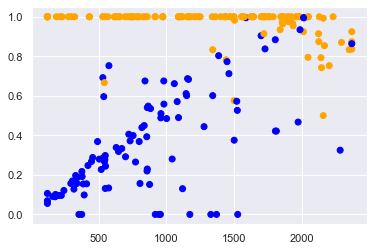

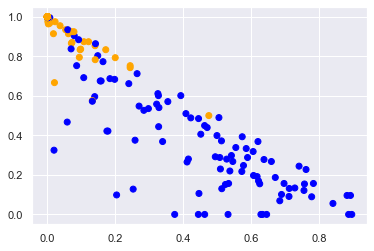

0.7072317938900339
0.20566286150857438
0.9242239393939317
0.053730017761989345


In [131]:
# def new_predict_at_times(bst, x_test, bins, aggreg=True, mode="surv"):
#     res = []
#     weights = []
#     for i in range(len(bst.models)):
#         res.append(bst.models[i].predict_at_times(x_test, bins=bins,
#                                                    mode=mode))
#         weights.append(np.ones_like(x_test.shape[1]))
# #         weights.append(bst.models[i].get_ibs_by_leaf(x_test))

#     res = np.array(res)
#     weights = np.vstack(weights).T
#     print(weights[:3])
#     if aggreg:
#         res = bst.get_aggreg(res, weights)
#     return res

pred_surv = bst.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()

plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)))

In [125]:
metr.ibs_WW(y_tr, y_HO[~y_HO["cens"]], pred_surv[~y_HO["cens"]], bins_HO, axis=0) + metr.auprc(y_tr, y_HO[~y_HO["cens"]], pred_surv[~y_HO["cens"]], bins_HO, axis=0) 

array([0.99998   , 0.99998   , 0.99998   , 0.99998   , 0.94227059,
       0.99998   , 0.99998   , 1.00114629, 0.97334067, 0.99998   ,
       0.9861927 , 0.99998   , 0.96645028, 0.99998   , 0.99998   ,
       0.993838  , 0.99998   , 0.97556726, 0.97595706, 0.99998   ,
       0.97856112, 0.99998   , 0.99998   , 0.88879324, 0.99998   ,
       0.93412917, 0.99998   , 0.99998   , 0.99998   , 0.99998   ,
       0.99998   , 0.99998   , 0.99998   , 0.99998   , 0.99998   ,
       0.99998   , 0.99998   , 0.99737452, 0.99998   , 0.99998   ,
       0.99998   , 0.99998   , 0.99998   , 0.99998   , 0.99273581,
       0.98805477, 0.99998   , 0.99998   , 0.99998   , 0.99998   ,
       0.70814689, 0.99998   , 0.98420313, 0.98108126, 0.99998   ,
       0.99998   , 0.99998   , 0.92357639, 0.93618099, 0.99998   ,
       0.99998   , 0.99998   , 0.99998   , 0.99998   , 0.99998   ,
       0.99998   , 1.00516391, 0.99484667, 0.99998   , 0.99998   ,
       0.99998   , 0.99998   , 0.99998   , 0.99998   , 0.99998

In [127]:
np.trapz((pred_surv**2), bins_HO) < bins_HO[-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [111]:
a = metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)
np.sum(a > np.mean(a)), np.sum(a > np.median(a))

(94, 113)

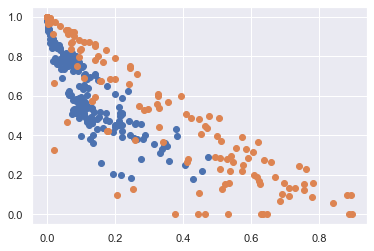

In [112]:
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0))
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv, bins_HO, axis=0))
plt.show()

In [113]:
# base wei
# 0.6758769131025578
# 0.1269199961988582
# 0.7179428388102345
# 0.0685427525921462

# wei with best n
# 0.7074132286416197
# 0.16227732270824163
# 0.7974112156361877
# 0.06139413474638451

# wei with best n + sum ibs 
# 0.6848770018214202
# 0.16023598514630807
# 0.8212744870487891
# 0.05994671403197158

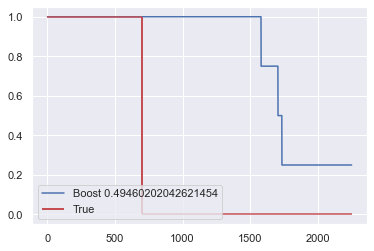

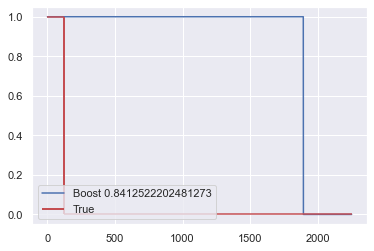

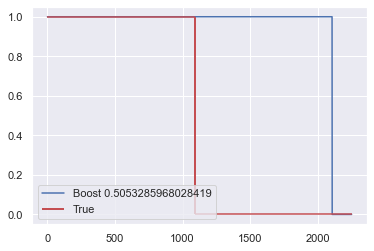

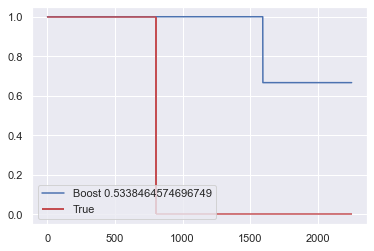

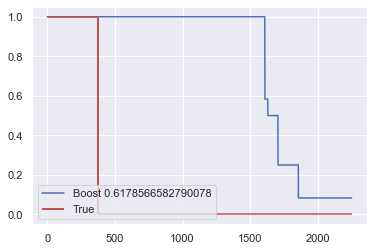

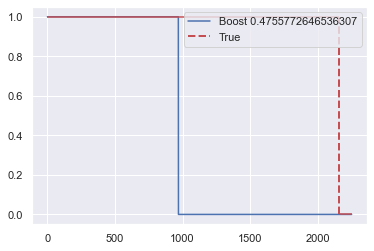

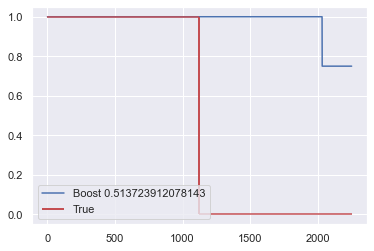

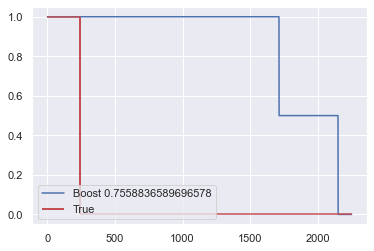

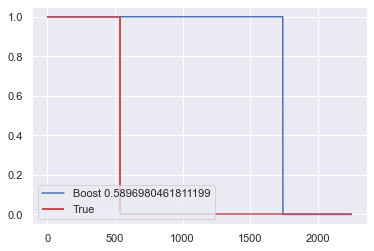

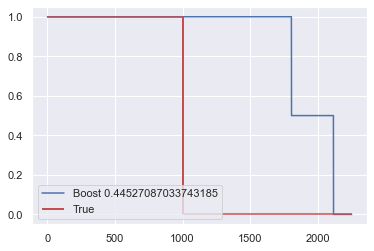

In [114]:
def print_true_pred(y_true, y_preds, labels):
    fig, ax = plt.subplots()
    
    for y_pred, label in zip(y_preds, labels):
        ax.plot(y_pred, label = label)
    ax.hlines(1.0, 0, y_true["time"], color = 'r')
    ax.hlines(0.0, y_true["time"], len(y_preds[0]), color = 'r')
    ax.vlines(y_true["time"], 0, 1, 
                  color = 'r', 
                  linestyles = ('solid' if y_true["cens"] else 'dashed'),
                  linewidth = 2, 
                  label = "True")
    ax.legend()
    plt.show()
    
# ind = np.where(metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0) > 0.4)
# for i in ind:
#     y_tr[ind], pred_surv[ind]

ibs_l = metr.ibs_WW(y_tr, y_HO, pred_surv, bins_HO, axis=0)
worst = np.where(ibs_l > 0.4)[0][:10]
# better = np.where(ibs_l < 0.01)[0][:5]
for i in np.hstack([worst]):
    print_true_pred(y_HO[i], 
                    [pred_surv[i]],
                    [f"Boost {ibs_l[i]}"])

In [918]:
X_HO.iloc[worst]

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm


In [870]:
weights = []
for i in range(len(bst.models)):
    weights.append(bst.models[i].get_ibs_by_leaf(X_HO.iloc[worst]))

wei = np.vstack(weights).T
bounds = 1 / np.sum(1 / wei, axis=1)
# wei = 1 / wei * (1 / np.sum(1 / wei, axis=1)).reshape(-1, 1)
wei, bounds

(array([[5.30117887e-02, 2.94050863e-02, 1.04055744e-01, 9.65291647e-02,
         2.79627164e-02, 1.03479784e-01, 1.00000000e-15, 4.28939192e-02,
         1.30863324e-02, 9.30270948e-02, 7.70286348e-02, 6.19225281e-02,
         7.14567244e-02, 1.02553575e-01, 7.64686798e-02, 7.86085026e-02,
         5.47280602e-02, 9.00531063e-02, 3.96780303e-02, 4.01268733e-02,
         3.83311141e-02, 1.02366339e-01, 8.45974384e-02, 2.86396245e-02,
         1.03805470e-01, 5.48990235e-02, 8.48087324e-02, 1.23236949e-01,
         2.11442159e-02, 7.04616067e-02, 8.46422876e-02, 1.57082224e-02,
         3.50643586e-02, 7.75357301e-02, 9.78766245e-02, 2.99594062e-02,
         6.98878546e-02, 1.79874387e-02, 9.25009455e-02, 9.23472861e-02,
         6.23612960e-02, 7.90367456e-02, 2.59376387e-02, 4.27547850e-02,
         3.00221926e-02, 9.56947725e-02, 5.95277376e-02, 5.32623169e-02,
         2.33300044e-02, 7.26320462e-02],
        [5.30117887e-02, 3.53084792e-02, 5.47510147e-02, 3.41129523e-02,
         

In [270]:
weights.sum(axis=1).shape

(91,)

In [447]:
ibs_by_obs = metr.ibs_WW(y_test, y_test, pred_surv, bins, axis=0)

In [ ]:
weights = []
for i in range(len(bst.models)):
    weights.append(bst.models[i].predict(X_test))

weights = np.vstack(weights).T
bounds = 1 / np.sum(1 / weights, axis=1)

In [509]:
y_test[0]

(False, 1233.)

In [510]:
wei1 = 1 / weights1 * (1 / np.sum(1 / weights1, axis=1)).reshape(-1, 1)
wei2 = 1 / weights2 * (1 / np.sum(1 / weights2, axis=1)).reshape(-1, 1)
wei1[1], wei2[1]

(array([0.00309332, 0.025786  , 0.3172415 , 0.00858844, 0.3172415 ,
        0.3172415 , 0.00228493, 0.00239279, 0.00346641, 0.0026636 ]),
 array([0.06099068, 0.08138921, 0.08016715, 0.07429709, 0.04398791,
        0.19834669, 0.10951995, 0.10005063, 0.12933694, 0.12191376]))

In [505]:
res = []
weights = []
for i in range(len(bst.models)):
    pred_surv2 = bst.models[i].predict_at_times(X_test, bins=bins, mode="surv")
    res.append(pred_surv2)
    print(np.round(metr.ibs_WW(y_test, y_test, pred_surv2, bins, axis=0), 5), 
          bst.models[i].get_ibs_by_leaf(X_test))
#     weights.append(metr.ibs_WW(y_test, y_test, pred_surv2, bins, axis=0))
    weights.append(bst.models[i].get_ibs_by_leaf(X_test))

res = np.array(res)
weights1 = np.vstack(weights).T

bounds = 1 / np.sum(1 / weights, axis=1)
res = bst.get_aggreg(res, weights)
ibs_by_obs = metr.ibs_WW(y_test, y_test, res, bins, axis=0)

[0.13399 0.4751  0.08982 0.00427 0.21758 0.      0.01103 0.46606 0.07411
 0.46339 0.33575 0.13513 0.24556 0.      0.47439 0.07382 0.14165 0.27265
 0.19311 0.44959 0.7349  0.17102 0.13858 0.22014 0.      0.      0.14901
 0.49078 0.07096 0.00494 0.12256 0.67906 0.16419 0.43986 0.35435 0.38161
 0.02724 0.26306 0.123   0.11269 0.21909 0.17751 0.38605 0.      0.06731
 0.09325 0.17274 0.      0.      0.72136 0.06605 0.11767 0.      0.14361
 0.      0.16419 0.11978 0.01105 0.19591 0.01121 0.00104 0.33544 0.6571
 0.0192  0.13369 0.23762 0.17544 0.06785 0.14136 0.24306 0.      0.01021
 0.      0.41677 0.60718 0.      0.17275 0.      0.      0.3659  0.00944
 0.00271 0.30984 0.23224 0.15973 0.00511 0.81306 0.22835 0.2389  0.
 0.57993 0.16419] [0.08379725 0.10255698 0.06801281 0.03999378 0.001      0.001
 0.07106211 0.0732911  0.03373193 0.0732911  0.09722229 0.02337689
 0.001      0.001      0.06801281 0.00687844 0.001      0.001
 0.06632831 0.03999378 0.001      0.09722229 0.07106211 0.08379725


[1.1850e-02 2.6458e-01 4.2260e-02 5.3300e-03 7.2891e-01 0.0000e+00
 3.7200e-03 7.0830e-02 6.1027e-01 2.6640e-02 1.2078e-01 1.7496e-01
 5.4618e-01 2.0416e-01 5.2265e-01 3.8264e-01 2.9067e-01 1.5760e-01
 7.1270e-02 1.4303e-01 4.3354e-01 1.1452e-01 1.5086e-01 8.9300e-03
 5.7016e-01 1.1281e-01 7.3530e-02 8.7250e-02 1.7091e-01 8.0300e-03
 1.2473e-01 3.5741e-01 2.0650e-02 4.4630e-02 3.7314e-01 2.1670e-01
 0.0000e+00 6.1654e-01 0.0000e+00 7.6870e-02 4.2335e-01 4.0453e-01
 0.0000e+00 2.8271e-01 4.3756e-01 5.2250e-02 8.7950e-02 2.4000e-04
 8.4910e-02 8.6440e-02 1.1820e-02 2.6599e-01 5.1630e-02 6.5090e-02
 8.4800e-03 9.8510e-02 1.1979e-01 1.0300e-02 1.3658e-01 1.4239e-01
 5.7549e-01 2.3849e-01 6.6933e-01 1.3254e-01 1.4693e-01 2.3695e-01
 1.6040e-01 1.9203e-01 2.7614e-01 1.3674e-01 0.0000e+00 2.9015e-01
 2.3390e-02 1.5446e-01 5.3540e-02 9.6460e-02 1.5550e-02 1.8327e-01
 1.0380e-02 2.2669e-01 4.1900e-03 0.0000e+00 3.2244e-01 9.5120e-02
 1.0031e-01 2.9990e-02 1.6874e-01 1.1945e-01 3.7922e-01 5.3580

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [483]:
for b, i in zip(bounds, ibs_by_obs):
    print(np.round(b*10, 5), np.round(i, 5), 10*b + 1e-5 >= i)

0.00241 0.13692 False
0.00317 0.27597 False
0.00379 0.00532 False
0.00391 0.13831 False
0.00239 0.1784 False
0.001 0.00647 False
0.00234 0.05835 False
0.00223 0.09228 False
0.00227 0.11707 False
0.00194 0.02821 False
0.00314 0.23522 False
0.00164 0.28329 False
0.00223 0.39993 False
0.00235 0.00125 True
0.00163 0.44876 False
0.00171 0.10665 False
0.00246 0.25967 False
0.0019 0.17954 False
0.00211 0.2472 False
0.00324 0.24649 False
0.00141 0.10382 False
0.00394 0.14675 False
0.00728 0.21603 False
0.00312 0.03159 False
0.00234 0.13428 False
0.00184 0.02012 False
0.00454 0.03106 False
0.00247 0.30296 False
0.00235 0.09467 False
0.00298 0.12206 False
0.00197 0.09565 False
0.00292 0.07948 False
0.00214 0.15638 False
0.00388 0.04493 False
0.00226 0.26001 False
0.00438 0.06378 False
0.00827 0.00068 True
0.00191 0.14106 False
0.00141 0.00273 False
0.00317 0.07908 False
0.00235 0.06545 False
0.00293 0.09401 False
0.00278 0.35919 False
0.00231 0.01469 False
0.00399 0.10589 False
0.00302 0.01522 F

In [341]:
res = []
weights = []
for i in range(len(bst.models)):
#     print(bst.models[i].ibs_leaf)
#     res.append(bst.models[i].predict(X, target="time"))
    res.append(bst.models[i].predict_at_times(X, bins=bins,
                                               mode="surv"))
    weights.append(bst.models[i].get_ibs_by_leaf(X))

res = np.array(res)
weights = np.vstack(weights).T

# weights, res, 
bst.get_aggreg(res, weights)

array([[1.        , 1.        , 1.        , ..., 0.09107231, 0.09107231,
        0.09107231],
       [1.        , 1.        , 1.        , ..., 0.94536287, 0.92743919,
        0.91523975],
       [1.        , 1.        , 1.        , ..., 0.76351195, 0.76351195,
        0.76351195],
       ...,
       [1.        , 1.        , 1.        , ..., 0.87007092, 0.87007092,
        0.86330681],
       [1.        , 1.        , 1.        , ..., 0.81047918, 0.81047918,
        0.81047918],
       [1.        , 1.        , 1.        , ..., 0.72988879, 0.72988879,
        0.71388379]])

In [342]:
y

array([( True,  400.), (False, 4500.), ( True, 1012.), ( True, 1925.),
       (False, 1504.), ( True, 2503.), (False, 1832.), ( True, 2466.),
       ( True, 2400.), ( True,   51.), ( True, 3762.), ( True,  304.),
       (False, 3577.), ( True, 1217.), ( True, 3584.), (False, 3672.),
       ( True,  769.), ( True,  131.), (False, 4232.), ( True, 1356.),
       (False, 3445.), ( True,  673.), ( True,  264.), ( True, 4079.),
       (False, 4127.), ( True, 1444.), ( True,   77.), ( True,  549.),
       (False, 4509.), ( True,  321.), ( True, 3839.), (False, 4523.),
       ( True, 3170.), (False, 3933.), ( True, 2847.), (False, 3611.),
       ( True,  223.), ( True, 3244.), ( True, 2297.), (False, 4467.),
       ( True, 1350.), (False, 4453.), (False, 4556.), ( True, 3428.),
       (False, 4025.), ( True, 2256.), (False, 2576.), (False, 4427.),
       ( True,  708.), ( True, 2598.), ( True, 3853.), ( True, 2386.),
       ( True, 1000.), ( True, 1434.), ( True, 1360.), ( True, 1847.),
      

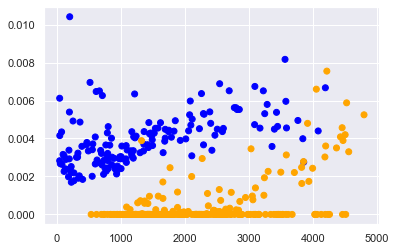

In [237]:
plt.scatter(bst.y_train["time"], bst.weights, c=np.where(bst.y_train["cens"], "blue", "orange"))

In [344]:
pred_sf = bst.predict_at_times(X, bins=bins, mode="surv")
metr.ibs(y, y, pred_sf, bins)

0.051495071595312816

In [187]:
i = bm.survival.survival_function.shape[0] - np.searchsorted(bm.survival.survival_function[::-1], 0.5)
print(i, bm.survival.survival_function[[i-1, i, i+1]])

16 [0.61688312 0.49350649 0.49350649]


In [188]:
bm.survival.timeline[i]

2234.0

2059.0
0.05020338538992599 0.05020338538992554
Integrated S(t): 297.935


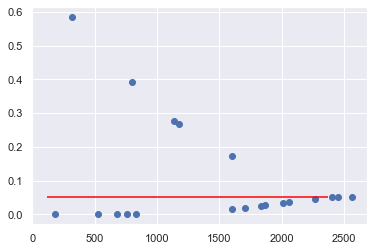

In [235]:
from survivors.tree.stratified_model import BaseFastSurviveModel, BaseFastSurviveModelZeroAfter

for i in range(1):
    X_ = X.copy()
    X_["time"] = y["time"]
    X_["cens"] = y["cens"]
    
    X_ = X_.sample(n=20)
    y_ = y[X_.index]

    bm = BaseFastSurviveModelZeroAfter()
    bm.fit(X_)
    pred_sf = bm.predict_survival_at_times(X_, bins)
    ibs_val = metr.ibs_WW(y_, y_, pred_sf, bins, axis=0)
    print(y_["time"][np.argmin(ibs_val[y_["cens"]])])
    
#     i = bm.survival.survival_function.shape[0] - np.searchsorted(bm.survival.survival_function[::-1], 0.5)
#     print(bm.survival.timeline[i], bm.survival.survival_function[[i-1, i, i+1]])

#     min_ibs = 1/(bm.survival.timeline[-1] - bm.survival.timeline[0])* np.trapz(np.where(bm.survival.survival_function[1:] >= 0.5, 
#                        (1 - bm.survival.survival_function[1:])**2, 
#                        (bm.survival.survival_function[1:])**2), bm.survival.timeline)
    min_ibs = 1/(bins[-1] - bins[0])* np.trapz(np.where(pred_sf[0] > 0.5, 
                       (1 - pred_sf[0])**2, 
                       (pred_sf[0])**2), bins)
    
    plt.scatter(y_["time"], ibs_val)
#     plt.vlines(x=np.trapz(pred_sf[0], bins), ymin=ibs_val.min(), ymax=ibs_val.max(), color="orange")
#     plt.vlines(x=bm.survival.timeline[i], ymin=ibs_val.min(), ymax=ibs_val.max(), color="green")
#     plt.vlines(x=y_[y_["cens"]]["time"][np.argmin(ibs_val[y_["cens"]])], ymin=ibs_val.min(), ymax=ibs_val.max(), color="red")
    plt.hlines(y=min_ibs, xmin=bins.min(), xmax=bins.max(), color="red")
    print(min_ibs, ibs_val[y_["cens"]].min())
    print(f"Integrated S(t): {np.trapz(ibs_val[np.argsort(y_['time'])], np.sort(y_['time'])):.3f}")

#     y_ = cnt.get_y(time=[np.trapz(pred_sf[0], bins)], cens=[True])
#     print(f"{np.trapz(pred_sf[0], bins):.3f}->{metr.ibs_WW(y_, y_, pred_sf[0][np.newaxis, :], bins):.3f}")

In [226]:
pred_sf[0], bins

(array([0.94736842, 0.94736842, 0.94736842, ..., 0.        , 0.        ,
        0.        ]),
 array([ 120,  121,  122, ..., 2370, 2371, 2372]))

In [225]:
bm.survival.survival_function, bm.survival.timeline

(array([1.        , 1.        , 0.94736842, 0.89473684, 0.84210526,
        0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.78947368,
        0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.67669173,
        0.67669173, 0.67669173, 0.67669173, 0.45112782, 0.45112782,
        0.45112782]),
 array([  16.,   72.,  491.,  502.,  552., 1095., 1243., 1331., 1343.,
        1350., 1483., 1632., 1653., 1753., 1786., 1852., 1904., 1918.,
        2161., 2192.]))

In [223]:
y_[y_["cens"]][np.argmin(ibs_val[y_["cens"]])]

(True, 1918.)

In [207]:
ibs_val[np.argsort(y[X_.index]["time"])]

array([5.30097656e-01, 5.27699788e-01, 4.66252220e-05, 1.26776199e-03,
       3.79564797e-01, 2.27227985e-01, 7.66906847e-03, 7.78937819e-03,
       7.90968792e-03, 8.45108168e-03, 2.04248411e-01, 9.14801635e-03,
       1.41200884e-02, 2.93376422e-02, 3.25770225e-02, 3.43850487e-02,
       3.46110520e-02, 4.03741355e-02, 4.16924879e-02, 4.19938256e-02])

In [121]:
y[X_.index]["time"]

array([1990.,  275., 1838., 1645., 1113., 1120., 1840.,  503., 2172.,
        533., 1296., 1212.,  148., 1481., 1781.,  372., 1884., 1679.,
       1722., 1729.])